In [1]:
from scipy.special import kl_div, rel_entr
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon 
from scipy.stats import kstest 
from scipy.stats import wasserstein_distance
from scipy.stats import rv_histogram 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import scipy.stats as stat
from scipy.stats import iqr 

from sklearn.neighbors import KernelDensity

from IPython.display import display

In [13]:
device = 'cpu'
gen_dir = 'generated_data/'
models_dir = 'models/' 
results_dir = 'results/' 
plots = 'plots/qualitative/'

In [3]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
print('Number of training batches: ', train_batches)
print('Length of each batch: ', length)
print('Number of stocks: ', stocks)

Number of training batches:  79
Length of each batch:  256
Number of stocks:  434


In [4]:
vaeconv1 = np.load(gen_dir + 'vaeconv1.npy')
vaeconv3 = np.load(gen_dir + 'vaeconv3.npy')
vaefd1 = np.load(gen_dir + 'vaefd1.npy')
vaefd2 = np.load(gen_dir + 'vaefd2.npy')
vqvaeconv2 = np.load(gen_dir + 'vqvaeconv2.npy')
vqvaefd1 = np.load(gen_dir + 'vqvaefd1.npy')
timevaebase = np.load(gen_dir + 'timevaebase.npy')



In [11]:
generated = {
   'TIME VAE BASE':timevaebase,
   'VAE Convolutional 1':vaeconv1,
   'VAE Convolutional 2':vaeconv3,
   'VAE Dense Layers 1':vaefd1,
   'VAE Dense Layers 2':vaefd2,
   'VQ-VAE Convolutional':vqvaeconv2,
   'VQ-VAE Dense Layers':vqvaefd1,
             }

In [12]:
# Random batches
# index = np.random.randint(0, train_batches, 4)
index = [38, 25, 56, 24]
index

[38, 25, 56, 24]

In [7]:
data_eval = np.zeros((data.shape[0], data.shape[2], data.shape[1]))
# print(data_eval.shape)
for i in range(data.shape[0]):
    # print(i)
    batch = data[i, :, :].copy()
    batch = np.transpose(batch)
    data_eval[i] = batch
data_eval.shape

(79, 434, 256)

In [16]:
def plot_density(real, synth):
    real = pd.DataFrame(real)
    real['label'] = 'Real distribution'
    real.columns = ['value', 'label']
    synth =synth.flatten()
    synth = pd.DataFrame(synth)
    synth['label'] = 'Synthetic distribution'
    synth.columns = ['value', 'label']
    df = pd.concat([real, synth])
    g =sns.histplot(df,
    bins='auto',
    kde=True,
    x = 'value',
    hue='label',
    stat="density",
    # facet_kws={'legend_out': False}, 
    alpha=0.3,
    common_bins=False,
    # ax=axes[i//2, i%2]
            )
    g.set(xlabel= None, ylabel= None )
    g.legend_.set_title(None)
    plt.show()

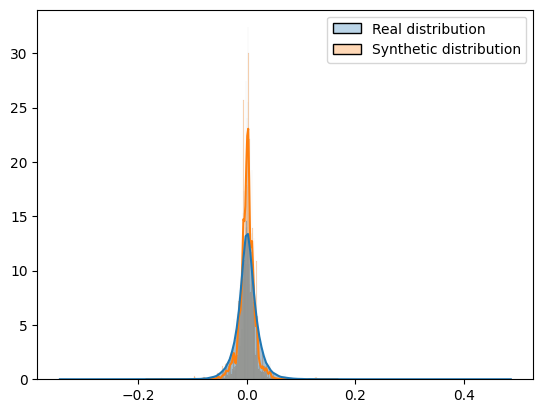

In [17]:
i = 0
real = data_eval[i].flatten()
synth =vqvaeconv2.flatten()
plot_density(real, synth)

In [18]:
def remove_outliers(data, m=3,verbose = False):

    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    data_clean = data[z_scores < m]

    # d = np.abs(data - np.median(data))
    # mdev = np.median(d)
    # s = d/mdev if mdev else np.zeros(len(d))
    # data_clean = data[s<m]

    # q1 = np.quantile(data, 0.25)
    # q3 = np.quantile(data, 0.75)
    # iqr = q3 - q1
    # lower = q1 - 1.5*iqr
    # upper = q3 + 1.5*iqr 
    # data_clean = data[(data > lower) & (data < upper)]

    if verbose:
        print('Reject outliers: %.2f%%' % ((data.shape[0]- data_clean.shape[0])/data.shape[0]*100))
        print('Max before: %.2f, Max now: %.2f' % (np.max(data), np.max(data_clean)))
        print('Min before: %.2f, Min now: %.2f' % (np.min(data), np.min(data_clean)))
    return data_clean
    
def get_domain(generated, real, sample=1000, drop_outliers=True):
    min_global = np.min(real)
    max_global = np.max(real)
    for model_name, synth in generated.items():    
        synth_flat =synth.flatten()
        if drop_outliers:
            synth_flat = remove_outliers(synth_flat)
        min_local = np.min(synth_flat)
        max_local = np.max(synth_flat)
        if min_local < min_global:
            min_global = min_local
        if max_local > max_global:
            max_global = max_local
    X = np.linspace(min_global, max_global, sample)
    return X

def histogram_pdf(array,X, long_tails=True,  w=None, bins='auto', density=True):
    #Get histogram
    hist, bin_edges =  np.histogram(array, bins=bins, density=density)
    # if w:
    #     print('Adding prior correction to histogram')
    #     histogram_dist = rv_histogram((
    #         np.histogram(array, bins=bins, density=density)[0] + w * np.ones(len(hist)),
    #         bin_edges)
    #         ,density=density)
    # else:
    histogram_dist = rv_histogram((hist, bin_edges),density=density)

    #Generate arrays of pdf evaluations
    if long_tails:
        X1 =[]
        for x in X:
            if x < bin_edges[0]:
                X1.append(bin_edges[0])
            elif x > bin_edges[-1]:
                X1.append(bin_edges[-2])
            else:
                X1.append(x)
                
        rvs_array = [histogram_dist.pdf(x) for x in X1]
    else:
        rvs_array = [histogram_dist.pdf(x) for x in X]
    # pdf = rvs_array/sum(rvs_array)
    return np.array(rvs_array)

def kernel_pdf(array, X, long_tails=True):
    #Get kernel density
    bandwidth = 1.06 * array.std() * array.size ** (-1 / 5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(array.reshape(-1, 1))
    
    if long_tails:
        #Generate arrays of pdf evaluations
        min_loc = np.min(array)
        max_loc = np.max(array)
        X1 =[]
        for x in X:
            if x < min_loc:
                X1.append(min_loc)
            elif x > max_loc:
                X1.append(max_loc)
            else:
                X1.append(x)
        X = np.array(X1)
        # X = np.linspace(np.min(array), np.max(array), sample)
        probabilities = np.exp(kde.score_samples(X.reshape(-1, 1)))
    else:
        probabilities = np.exp(kde.score_samples(X.reshape(-1, 1)))
    return probabilities

def get_pdf(array, X, by_hist=True, long_tails=True):

    if by_hist:
        pdf = histogram_pdf(array,X, long_tails)
        
    else:
        pdf = kernel_pdf(array, X, long_tails)
    return pdf

def calculate_jensen_shannon_divergence(p, q, ignore_zeros=True):
    """
    Implementation of pairwise `jensen_shannon divergence` between two 1-D arrays.
    """
    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)
    if ignore_zeros:
        cond = p!=0
        p = p[cond]
        q = q[cond]
    # calculate m
    m = (p + q) / 2
    # compute Jensen Shannon divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
    # divergence = (np.sum(kl_div(p, m)) + np.sum(kl_div(q, m))) / 2
    # compute the Jensen Shannon distance
    distance = np.sqrt(divergence)
    return distance


def get_divergences(synth_pdf, real_pdf, kl_sp=False):
# js = calculate_jensen_shannon_divergence(synth_pdf, real_pdf, ignore_zeros=ignore_zeros_js)
    js =jensenshannon(p = synth_pdf, q=real_pdf)
    # real_pdf_std = real_pdf/np.sum(real_pdf)
    # synth_pdf_std = synth_pdf/np.sum(synth_pdf)
    if kl_sp:
        return np.sum(kl_div(synth_pdf, real_pdf)), js
    else:
        entropy = rel_entr(synth_pdf, real_pdf)
        return np.sum(entropy), js  
def get_norms(synth_flat, real):
    l1 = np.linalg.norm(synth_flat - real, ord=1)
    l2 = np.linalg.norm(synth_flat - real)
    
    return l1, l2

def get_metrics(generated:dict, data_eval,
                by_hist= False, kl_sp=False, drop_outliers=True, long_tails=True, sample=1000):
    results ={}
    for i in range(data_eval.shape[0]):
        real = data_eval[i].flatten()
        if drop_outliers:
            real_clean = remove_outliers(real)
            X = get_domain(generated, real_clean, sample=sample ,drop_outliers=drop_outliers)
            real_pdf = get_pdf(real_clean, X, by_hist= by_hist, long_tails=True)
            real_pdf_flat = get_pdf(real, X, by_hist= by_hist, long_tails=False)
        else:
            X = get_domain(generated, real,  drop_outliers=drop_outliers)
            real_pdf = get_pdf(real, X, by_hist= by_hist, long_tails=True)
            real_pdf_flat = get_pdf(real, X, by_hist= by_hist, long_tails=False)

        results['data'+str(i)] = {}

        for model_name, synth in generated.items():
            model = model_name.strip()
            model = model.replace(' ', '-')
            results[model] = {}
            # print('Model: ', model)
        
            results['data'+str(i)][model] = {}
            
            synth_flat =synth.flatten()
            if drop_outliers:
                synth_clean = remove_outliers(synth_flat)
                synth_pdf= get_pdf(synth_clean, X, by_hist=by_hist, long_tails=True)
                synth_pdf_flat= get_pdf(synth_flat, X, by_hist=by_hist, long_tails=False)
            else:
                synth_pdf= get_pdf(synth_flat, X, by_hist=by_hist, long_tails=True)
                synth_pdf_flat= get_pdf(synth_flat, X, by_hist=by_hist, long_tails=False)

            kl, js = get_divergences(synth_pdf, real_pdf)
            
            ks = kstest(synth_flat, real, N=sample)
            wa = wasserstein_distance(synth_flat, real)
            l1, l2 = get_norms(synth_pdf_flat, real_pdf_flat)
            results['data'+str(i)][model]['Kullback-Leibler'] = kl
            results['data'+str(i)][model]['Jensen-Shannon'] = js
            results['data'+str(i)][model]['Kolmogorov-Smirnov'] = ks[0]
            results['data'+str(i)][model]['KS-pvalue'] = True if ks[1] > 0.05 else False
            results['data'+str(i)][model]['Wasserstein'] = wa 
            results['data'+str(i)][model]['L1'] = l1
            results['data'+str(i)][model]['L2'] = l2
    
    metrics = pd.concat({k: pd.DataFrame(v) for k, v in results.items()}, axis=0)
    metrics = metrics.reset_index()
    metrics = metrics.rename(columns={'level_0':'data', 'level_1':'metrics'})
    metrics = pd.melt(metrics, id_vars=['data', 'metrics'])
    metrics = metrics.rename(columns={'variable':'model', 'value':'score'})
    metrics = metrics.pivot(index=['model', 'metrics'], columns='data', values='score')
    metrics['Mean metrics'] = metrics.mean(axis=1) 

    metrics_mean = pd.DataFrame(metrics['Mean metrics'])
    metrics_mean = metrics_mean.reset_index()
    metrics_mean = metrics_mean.rename(columns={'model':'Model', 'metrics':'Metrics', 'Mean metrics':'Score'})
    metrics_mean = metrics_mean.pivot(index='Model', columns='Metrics', values='Score')
    metrics_mean = metrics_mean.drop('KS-pvalue', axis=1)
    metrics_mean = metrics_mean[['Jensen-Shannon','Kullback-Leibler', 'Kolmogorov-Smirnov', 'Wasserstein', 'L1', 'L2']]
    return metrics, metrics_mean




# Ploting distributions with outliers correction


Real:  111104
Reject outliers: 1.35%
Max before: 0.49, Max now: 0.07
Min before: -0.34, Min now: -0.06
Real clean:  109606
Model:  TIME-VAE-BASE
Synth:  (111104,)
Reject outliers: 0.92%
Max before: 0.04, Max now: 0.02
Min before: -0.10, Min now: -0.02
Synth clean:  110079


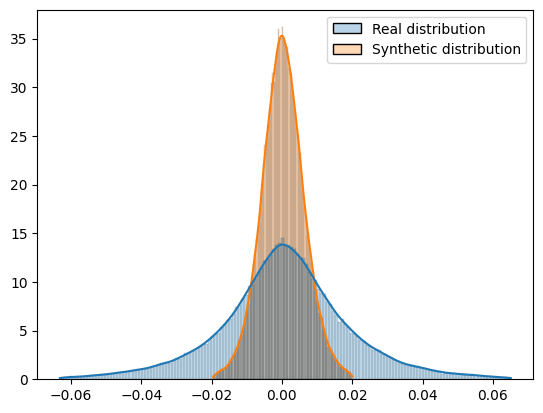

Model:  VAE-Convolutional-1
Synth:  (111104,)
Reject outliers: 0.54%
Max before: 0.04, Max now: 0.02
Min before: -0.04, Min now: -0.02
Synth clean:  110504


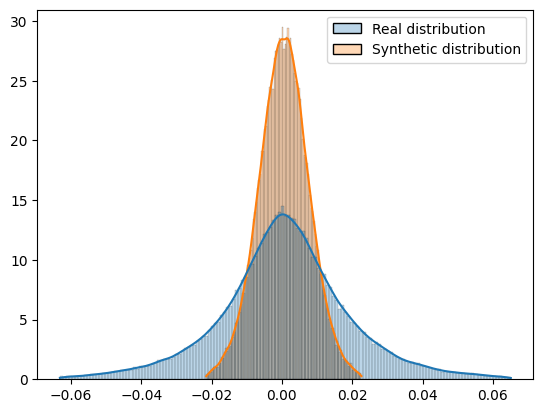

Model:  VAE-Convolutional-2
Synth:  (111104,)
Reject outliers: 0.37%
Max before: 0.15, Max now: 0.08
Min before: -0.13, Min now: -0.08
Synth clean:  110688


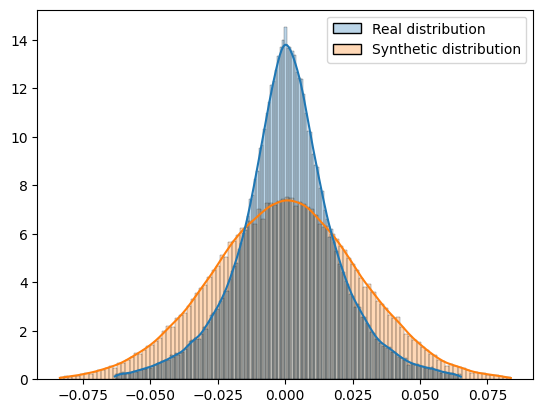

Model:  VAE-Dense-Layers-1
Synth:  (111104,)
Reject outliers: 0.95%
Max before: 0.11, Max now: 0.04
Min before: -0.09, Min now: -0.04
Synth clean:  110053


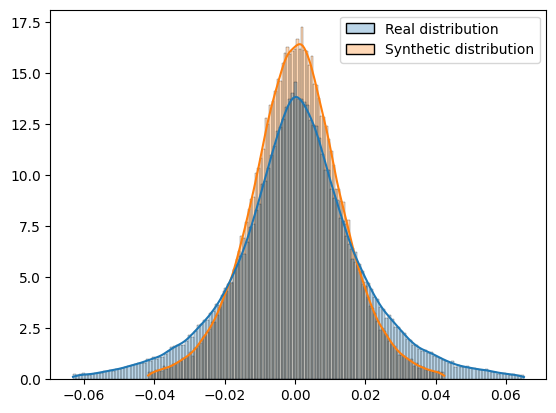

Model:  VAE-Dense-Layers-2
Synth:  (111104,)
Reject outliers: 0.78%
Max before: 0.04, Max now: 0.01
Min before: -0.04, Min now: -0.01
Synth clean:  110232


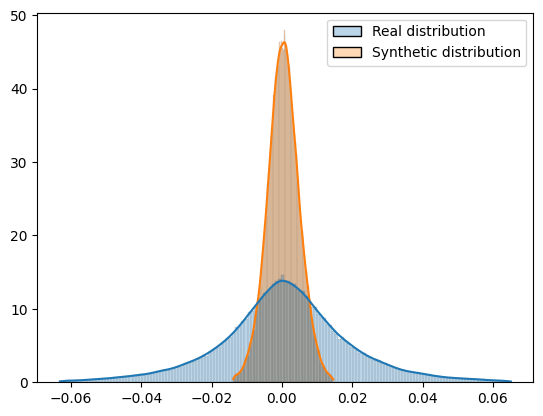

Model:  VQ-VAE-Convolutional
Synth:  (111104,)
Reject outliers: 1.34%
Max before: 0.17, Max now: 0.05
Min before: -0.18, Min now: -0.04
Synth clean:  109612


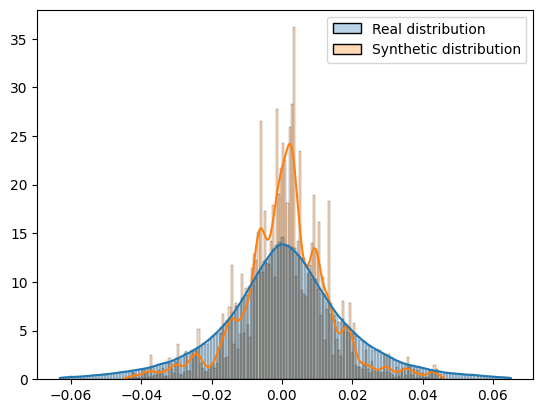

Model:  VQ-VAE-Dense-Layers
Synth:  (111104,)
Reject outliers: 0.39%
Max before: 0.06, Max now: 0.03
Min before: -0.04, Min now: -0.03
Synth clean:  110667


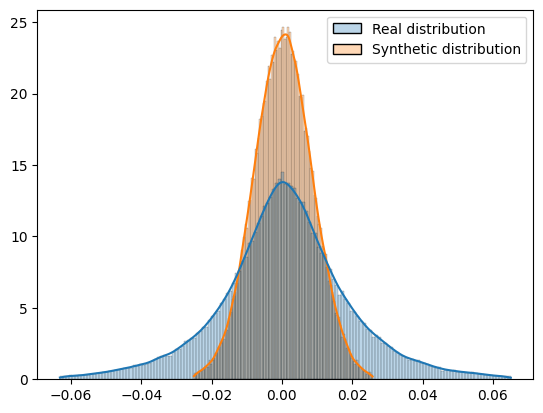

In [19]:

# m=10
print("Real: ", real.shape[0])
real_clean = remove_outliers(real,  verbose =True)
print("Real clean: ", real_clean.shape[0])
for model_name, synth in generated.items():
        model = model_name.strip()
        model = model.replace(' ', '-')
        synth_ft = synth.flatten()
        print('Model: ', model)       
        print("Synth: ", synth_ft.shape)
        synth_clean = remove_outliers(synth_ft, verbose =True)
        print("Synth clean: ", synth_clean.shape[0])
        plot_density(real_clean, synth_clean)
        

# Metrics 

# Removing Outliers - Kernel Density Estimation

In [12]:

by_hist=False
drop_outliers = True
metrics, metrics_mean = get_metrics(generated.copy(), data_eval.copy(), 
                    by_hist= by_hist, drop_outliers=drop_outliers)
metrics.to_csv(results_dir + 'metrics_kd.csv')
metrics_mean.to_csv(results_dir + 'metrics_mean_kd.csv')
display(metrics_mean)

Metrics,Jensen-Shannon,Kullback-Leibler,Kolmogorov-Smirnov,Wasserstein,L1,L2
Model,,,,,,
TIME-VAE-BASE,0.255173,1868.451676,0.165612,0.006551,3742.976729,240.591106
VAE-CONV1,0.20746,1313.756192,0.129287,0.005733,2969.731332,174.925501
VAE-CONV3,0.272664,2132.298968,0.172107,0.010746,3929.742495,193.025855
VAE-FD1,0.068272,201.419556,0.043728,0.001986,870.909033,47.741976
VAE-FD2,0.326593,3237.505406,0.220195,0.007849,5065.001428,357.908691
VQ-VAE-CONV2,0.090603,232.535703,0.055317,0.00191,1090.264753,69.709489
VQ-VAE-FD1,0.168447,858.410237,0.098923,0.004823,2250.767507,121.28936


## look metrics 

In [20]:
metrics = pd.read_csv(results_dir + 'metrics_kd.csv')
metrics

,model,metrics,data0,data1,data10,data11,data12,data13,data14,data15,...,data72,data73,data74,data75,data76,data77,data78,data8,data9,Mean metrics
0,VAE-CONV1,Jensen-Shannon,0.08653964506354099,0.08062794873150578,0.11104431484822834,0.10836636034404326,0.10593237898624712,0.09647015669659464,0.09958634512212482,0.10052306154251313,...,0.1003567880354755,0.10727582852424904,0.11589463468265239,0.11184826497189454,0.11228722592250656,0.10470228480653165,0.10368752386477822,0.07675998251611268,0.07490777089904067,0.098122
1,VAE-CONV1,KS-pvalue,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.000000
2,VAE-CONV1,Kolmogorov-Smirnov,0.18221237597153017,0.17517870057448426,0.14443321808659149,0.16083335835035217,0.16908315519984618,0.1817157224563361,0.17853934230710494,0.17720196407827693,...,0.1439848704669584,0.1301992207748076,0.12926225270052516,0.12904522102534866,0.13270830263347044,0.14487400141568452,0.1509502997141453,0.14055666805177125,0.13359103313832332,0.127757
3,VAE-CONV1,Kullback-Leibler,0.03016348333506092,0.026157692826576776,0.05054609558325672,0.047804645398541665,0.04550007073494075,0.03779135613976492,0.04032007525905497,0.04106088576975275,...,0.04125786000188377,0.047309006603017886,0.055566995771957554,0.05158361075483571,0.0520633469995811,0.04505069014773983,0.0442186610517581,0.023741947555810314,0.02267351763157522,0.040008
4,VAE-CONV1,Wasserstein,0.008272183862994682,0.00787194145916748,0.006060283952839432,0.0072703060802136454,0.008080014226476952,0.008680971920895094,0.008509690088609944,0.0085069288286124,...,0.005868615799582098,0.005278923711737232,0.004985705964734078,0.005161166356942718,0.005240969770908783,0.005920952415018565,0.005951825182226418,0.005475681927959393,0.0050962090742755345,0.004987
5,VAE-CONV3,Jensen-Shannon,0.09819514551697135,0.09230155111053898,0.12277216297939288,0.12016287041381891,0.11771754285490901,0.10855024477662775,0.11164312506180214,0.1125256177010557,...,0.11168563486644156,0.11864398271519552,0.1273696706281248,0.12330372628042947,0.12379862948097158,0.11600348505436288,0.1150231669919689,0.08868100257066709,0.0867571011567873,0.109725
6,VAE-CONV3,KS-pvalue,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.000000
7,VAE-CONV3,Kolmogorov-Smirnov,0.12399344422847644,0.12621627602272786,0.15819996166413464,0.13854899751145136,0.12406961842562195,0.11311047197643626,0.11790132073491275,0.11867718991841056,...,0.15895769966938333,0.1679468290488597,0.17298331043655293,0.1705390702534767,0.16786269417049282,0.15742701649931745,0.15429539568941358,0.16547035484272726,0.1710546952137082,0.176753
8,VAE-CONV3,Kullback-Leibler,0.03909338665575458,0.03449446876184668,0.0622685290515664,0.05919460272692076,0.056572077811415586,0.048180402223110846,0.051015599055787696,0.05180761259971996,...,0.05141850804369474,0.05826355627571649,0.06760007180177208,0.06314067901233061,0.06374904477269333,0.055678242293369457,0.05478770053980222,0.03190459873268808,0.03063207938501256,0.050201
9,VAE-CONV3,Wasserstein,0.007900968408547036,0.008296500445338476,0.01010906313152472,0.008900406959505986,0.008089490205464286,0.0074892863593013165,0.007656212912874496,0.007660615161565878,...,0.01031119135538229,0.010906623646017823,0.011231589900930187,0.011043162828542917,0.010973413405184344,0.010295028116285463,0.01029056106755779,0.01069383208784483,0.011070730261828334,0.011195


## Removing Outliers - Histogram Density Estimation

In [13]:
by_hist=True
drop_outliers = True
metrics, metrics_mean = get_metrics(generated.copy(), data_eval.copy(), 
                    by_hist= by_hist, drop_outliers=drop_outliers)
metrics.to_csv(results_dir + 'metrics_hist.csv')
metrics_mean.to_csv(results_dir + 'metrics_mean_hist.csv')
display(metrics_mean)

Metrics,Jensen-Shannon,Kullback-Leibler,Kolmogorov-Smirnov,Wasserstein,L1,L2
Model,,,,,,
TIME-VAE-BASE,0.237696,1906.290221,0.165612,0.006551,3704.011179,239.457213
VAE-CONV1,0.190744,1447.206438,0.129287,0.005733,2938.652878,173.701185
VAE-CONV3,0.264647,1836.701544,0.172107,0.010746,3958.594504,196.216409
VAE-FD1,0.07,290.339706,0.043728,0.001986,917.780798,52.366273
VAE-FD2,0.300895,3597.485131,0.220195,0.007849,5025.104681,356.282844
VQ-VAE-CONV2,0.175621,682.358648,0.055317,0.00191,2314.257009,153.939946
VQ-VAE-FD1,0.154591,891.332974,0.098923,0.004823,2224.480838,120.513903


## No Removing Outliers - Kernel Density Estimation

In [73]:
by_hist=False
drop_outliers = False
metrics, metrics_mean = get_metrics(generated.copy(), data_eval.copy(), 
                    by_hist= by_hist, drop_outliers=drop_outliers)
metrics.to_csv(results_dir + 'metrics_kd_no_outliers.csv')
metrics_mean.to_csv(results_dir + 'metrics_mean_kd_no_outliers.csv')
display(metrics_mean)

Metrics,Jensen-Shannon,Kullback-Leibler,Kolmogorov-Smirnov,Wasserstein
Model,,,,
VAE-CONV1,0.249269,inf,0.129287,0.005733
VAE-CONV3,0.275337,inf,0.172107,0.010746
VAE-FD1,0.080969,inf,0.043728,0.001986
VAE-FD2,0.379895,inf,0.220195,0.007849
VQ-VAE-CONV2,0.097427,inf,0.055317,0.00191
VQ-VAE-FD1,0.208866,inf,0.098923,0.004823


In [129]:
metrics_aux = metrics.reset_index()
# mtrics_aux = metrics_aux.drop('data')
metrics_aux = pd.melt(metrics_aux[metrics_aux['metrics']=='Kullback-Leibler'], id_vars=['model', 'metrics'])
# metrics_aux = metrics_aux[np.isfinite(metrics_aux['value']).all(1)]
metrics_aux =metrics_aux.replace([np.inf, -np.inf], np.nan)
metrics_aux=metrics_aux.dropna(subset=["value"])
metrics_aux = metrics_aux.pivot(index=['model', 'metrics'], columns='data', values='value')

metrics_aux['Mean metrics'] = metrics_aux.mean(axis=1) 

metrics_kl = pd.DataFrame(metrics_aux['Mean metrics'])
metrics_kl = metrics_kl.reset_index()
metrics_kl = metrics_kl.rename(columns={'model':'Model', 'metrics':'Metrics', 'Mean metrics':'Score'})


In [128]:

for i in range(0, metrics_mean.shape[0]):
    metrics_mean['Kullback-Leibler'][i] = metrics_kl['Score'][i]
metrics_mean

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_26402/2533718411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_mean['Kullback-Leibler'][i] = metrics_kl['Score'][i]
/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_26402/2533718411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_mean['Kullback-Leibler'][i] = metrics_kl['Score'][i]
/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_26402/2533718411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Metrics,Jensen-Shannon,Kullback-Leibler,Kolmogorov-Smirnov,Wasserstein
Model,,,,
VAE-CONV1,0.249269,449.795078,0.129287,0.005733
VAE-CONV3,0.275337,646.310007,0.172107,0.010746
VAE-FD1,0.080969,98.951738,0.043728,0.001986
VAE-FD2,0.379895,896.666834,0.220195,0.007849
VQ-VAE-CONV2,0.097427,295.360168,0.055317,0.00191
VQ-VAE-FD1,0.208866,302.347290,0.098923,0.004823


## look up results - pdf

### Removing Outliers - Kernel Density Estimation

Real:  111104
Reject outliers: 1.35%
Max before: 0.49, Max now: 0.07
Min before: -0.34, Min now: -0.06
Real clean:  109606
Real pdf area:  0.9999999999999999
Model:  TIME-VAE-BASE
Synth:  (111104,)
Reject outliers: 0.92%
Max before: 0.04, Max now: 0.02
Min before: -0.10, Min now: -0.02
Synth clean:  110079


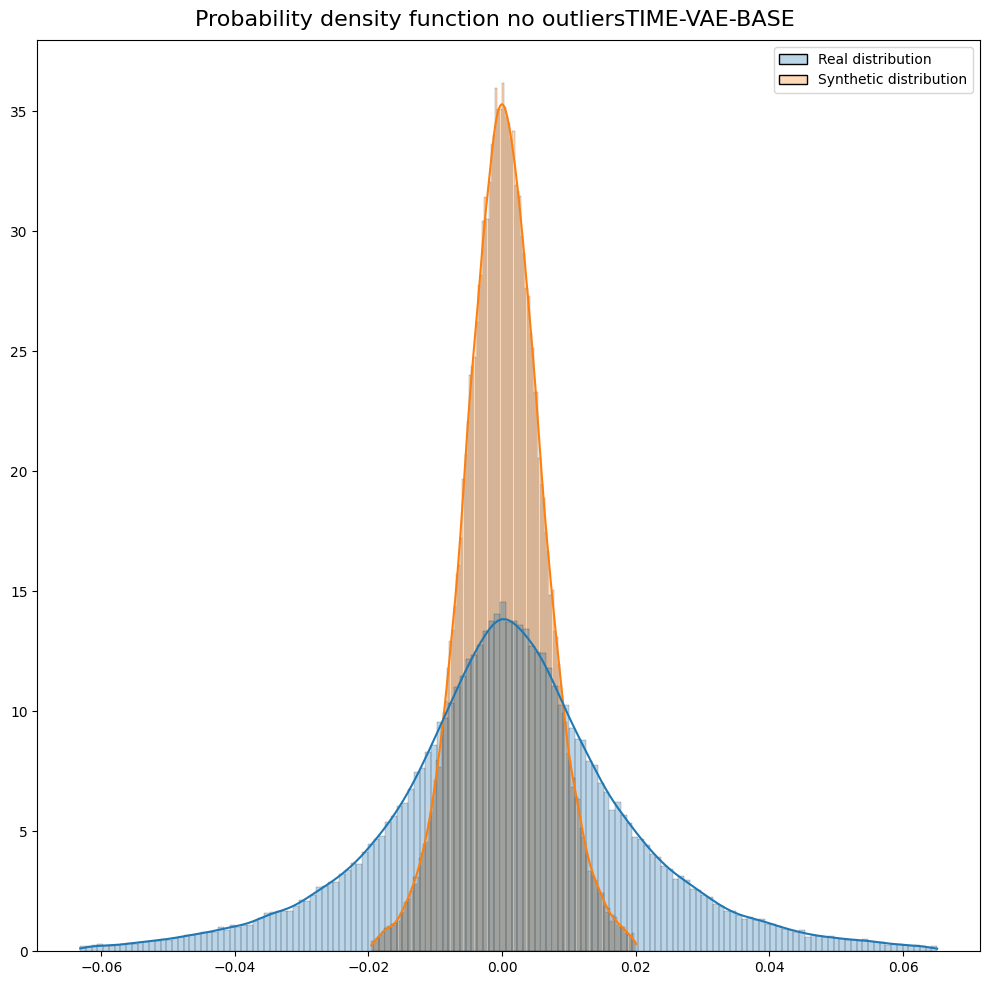

Synth pdf area:  1.0


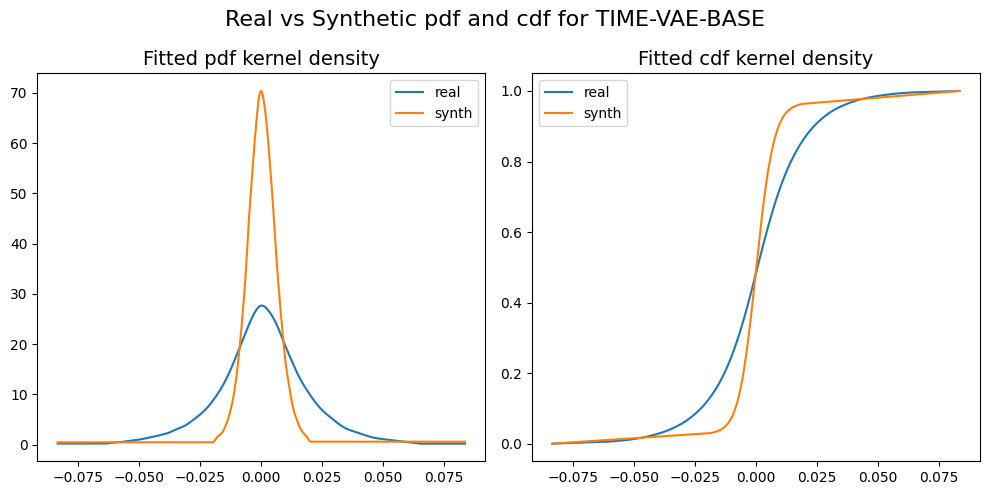

Model:  VAE-Convolutional-1
Synth:  (111104,)
Reject outliers: 0.54%
Max before: 0.04, Max now: 0.02
Min before: -0.04, Min now: -0.02
Synth clean:  110504


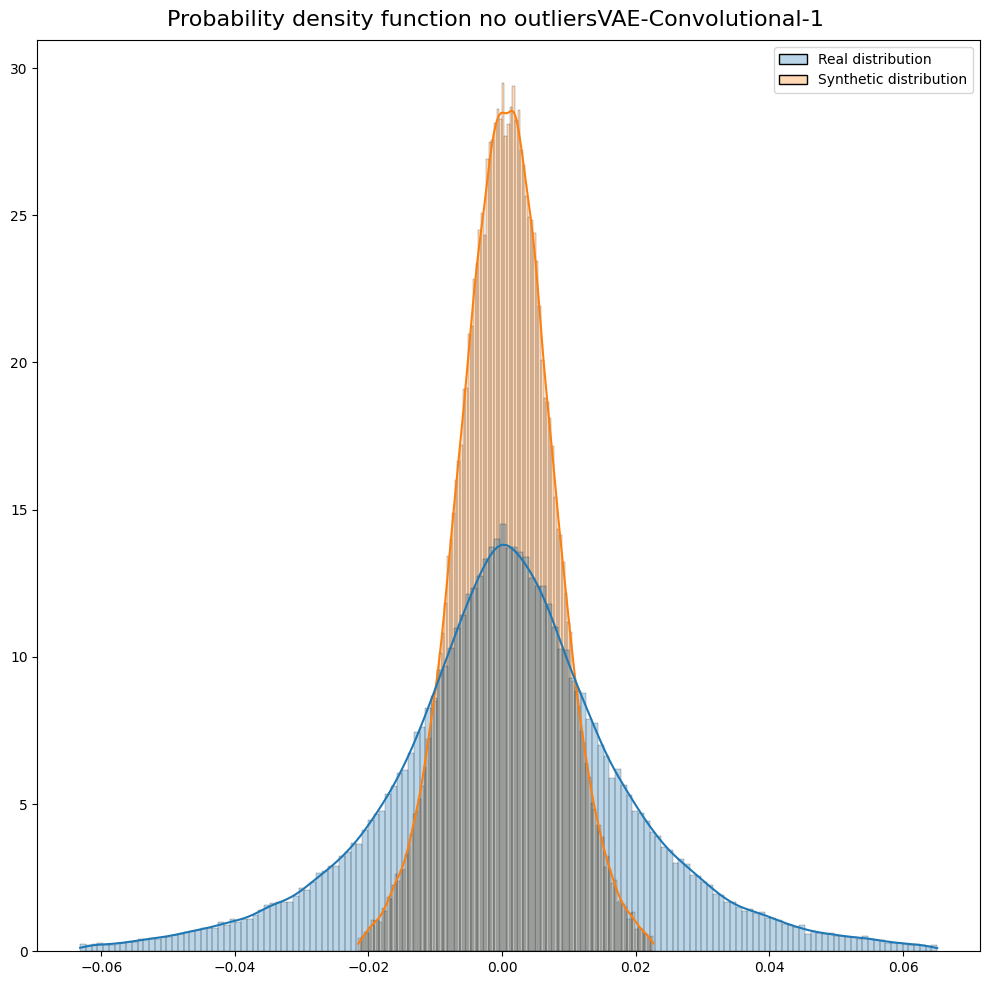

Synth pdf area:  1.0


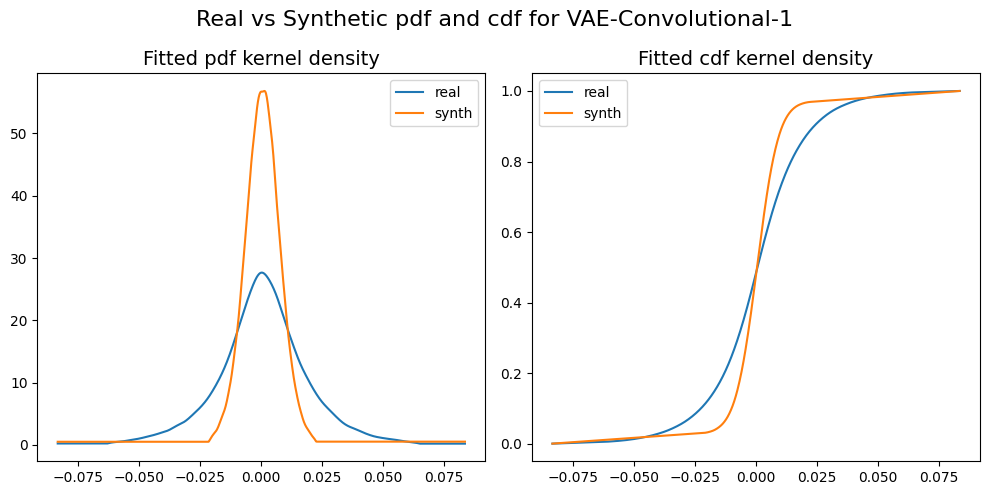

Model:  VAE-Convolutional-2
Synth:  (111104,)
Reject outliers: 0.37%
Max before: 0.15, Max now: 0.08
Min before: -0.13, Min now: -0.08
Synth clean:  110688


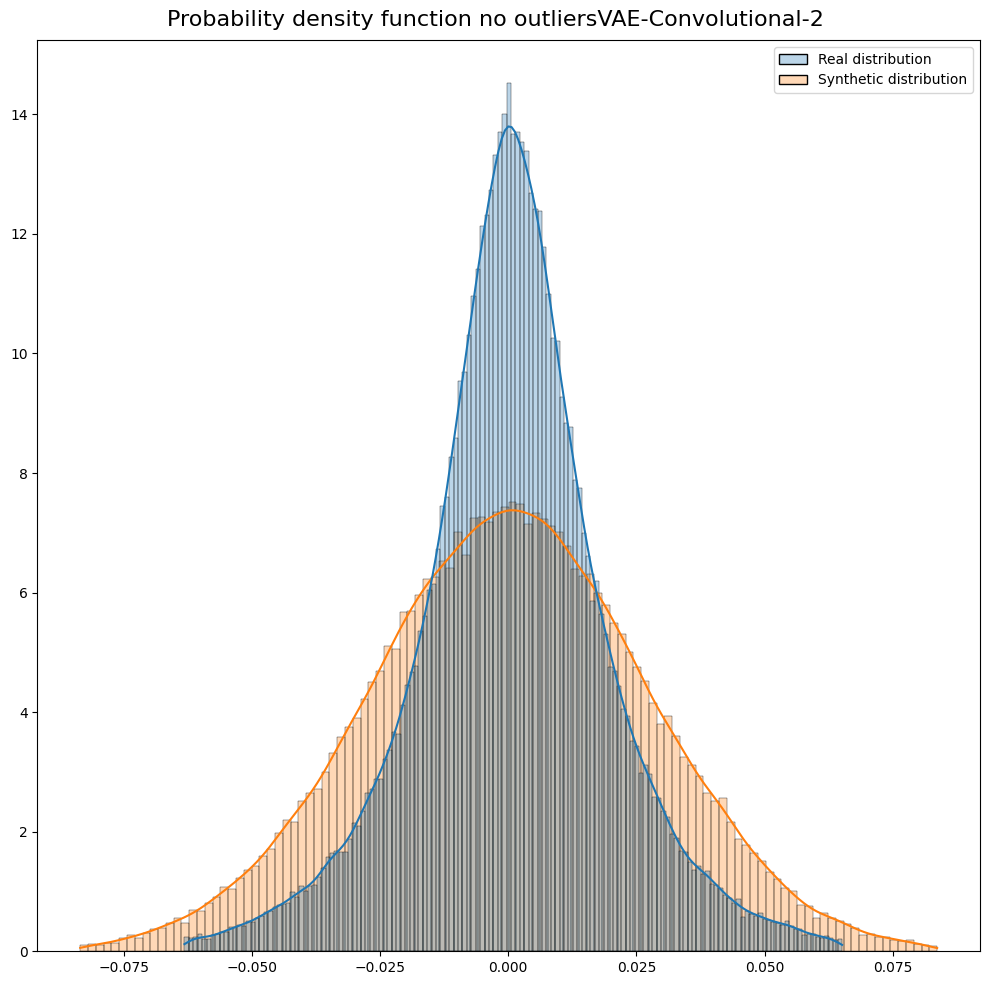

Synth pdf area:  1.0


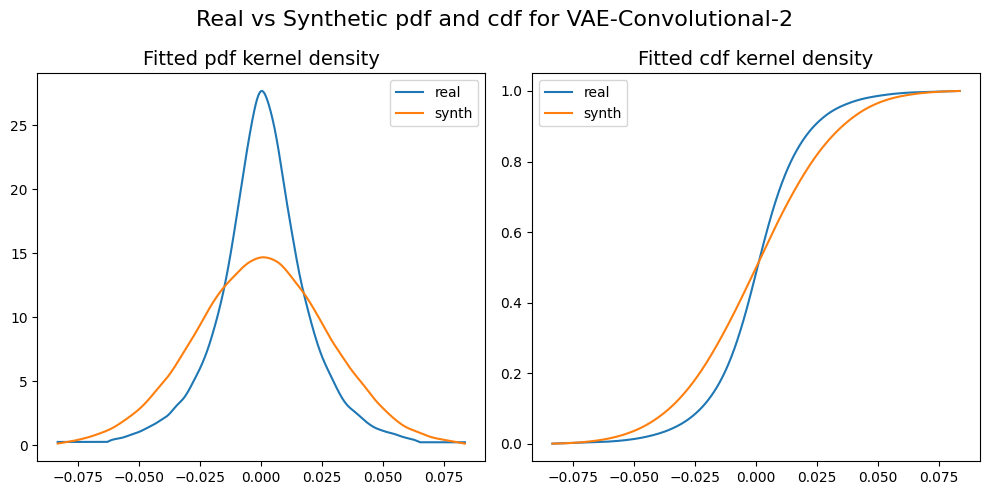

Model:  VAE-Dense-Layers-1
Synth:  (111104,)
Reject outliers: 0.95%
Max before: 0.11, Max now: 0.04
Min before: -0.09, Min now: -0.04
Synth clean:  110053


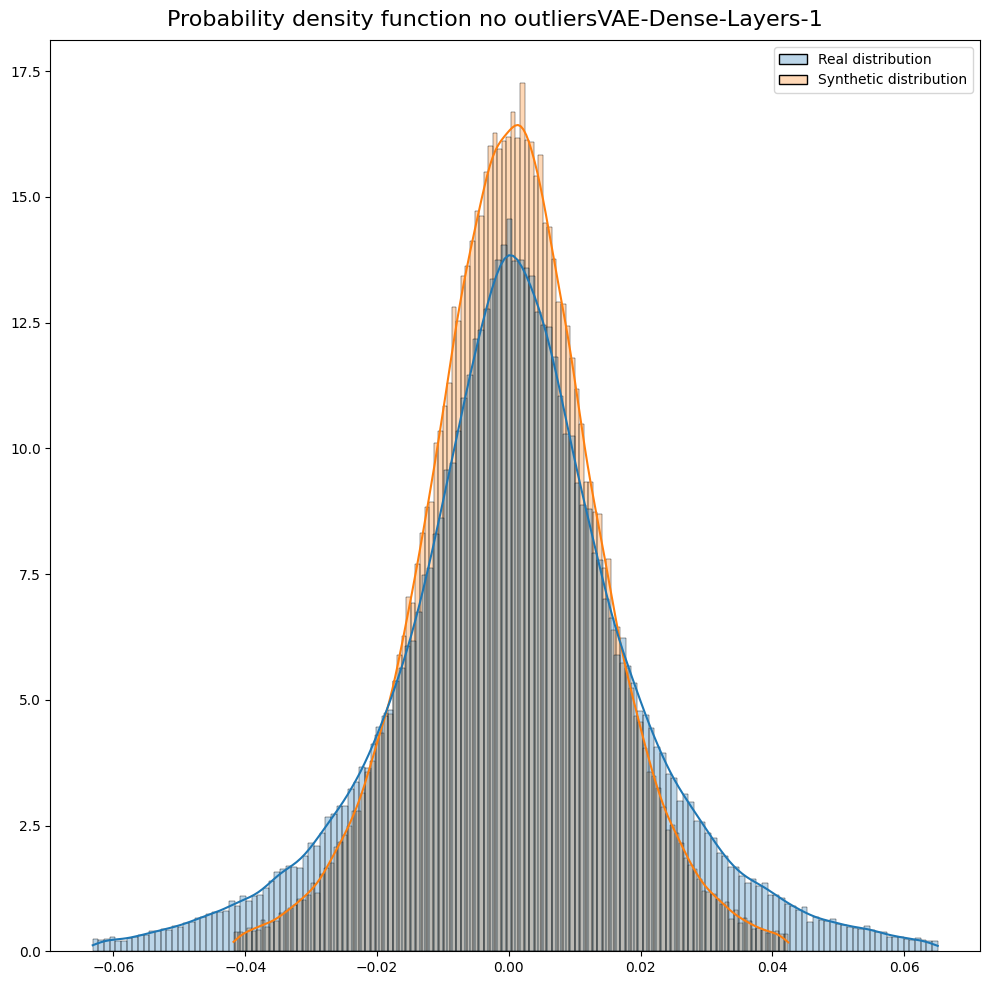

Synth pdf area:  1.0


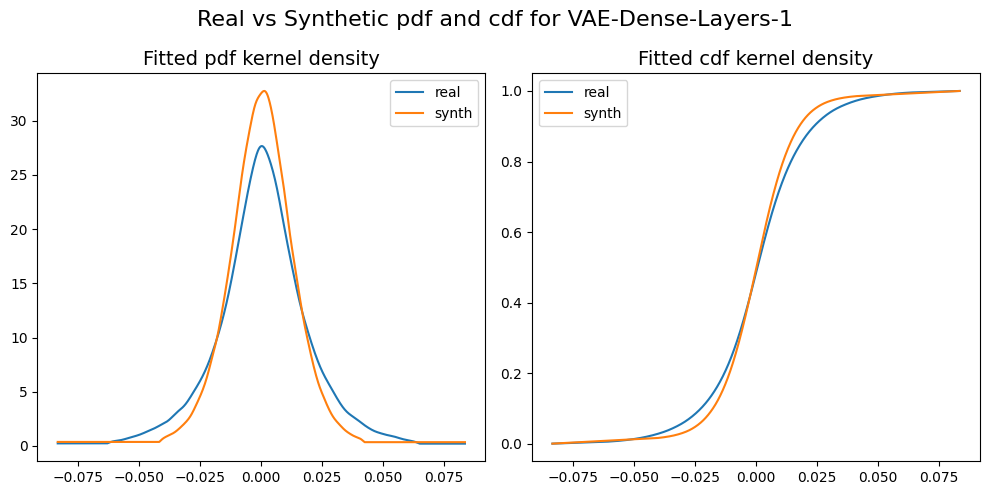

Model:  VAE-Dense-Layers-2
Synth:  (111104,)
Reject outliers: 0.78%
Max before: 0.04, Max now: 0.01
Min before: -0.04, Min now: -0.01
Synth clean:  110232


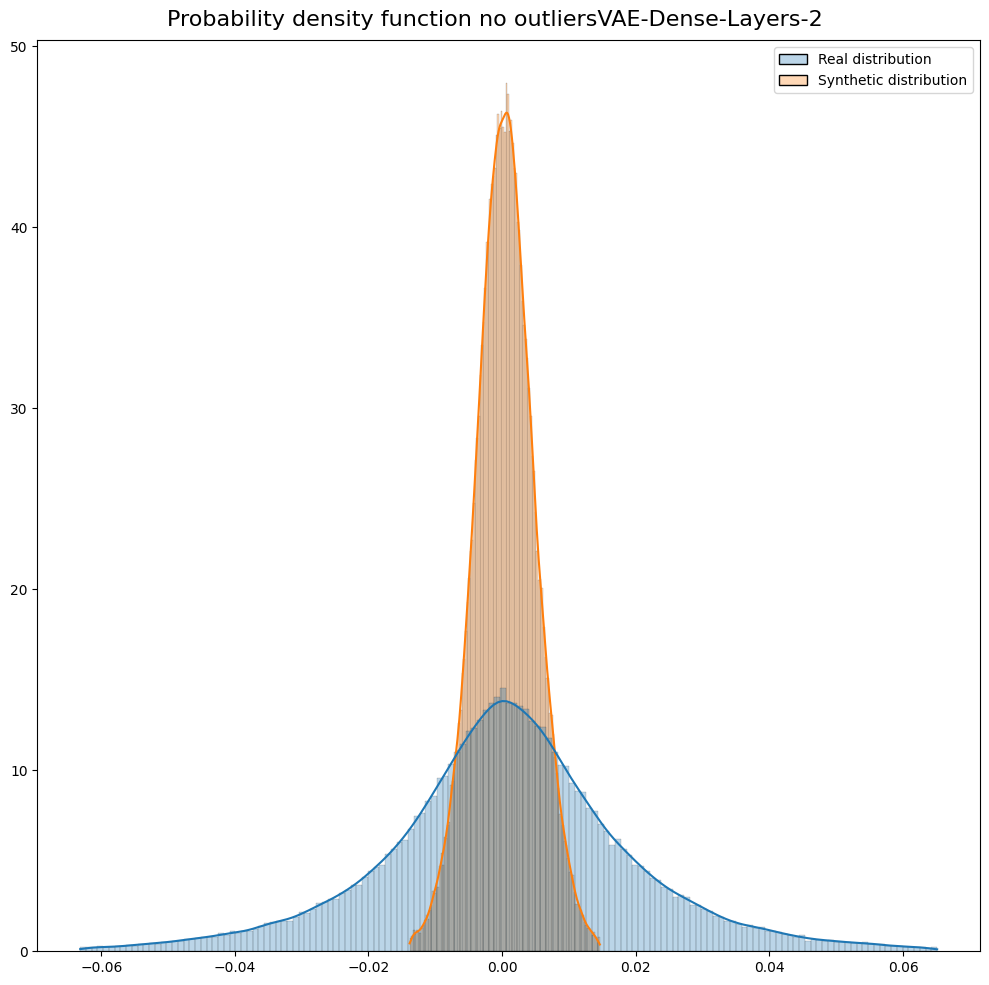

Synth pdf area:  1.0


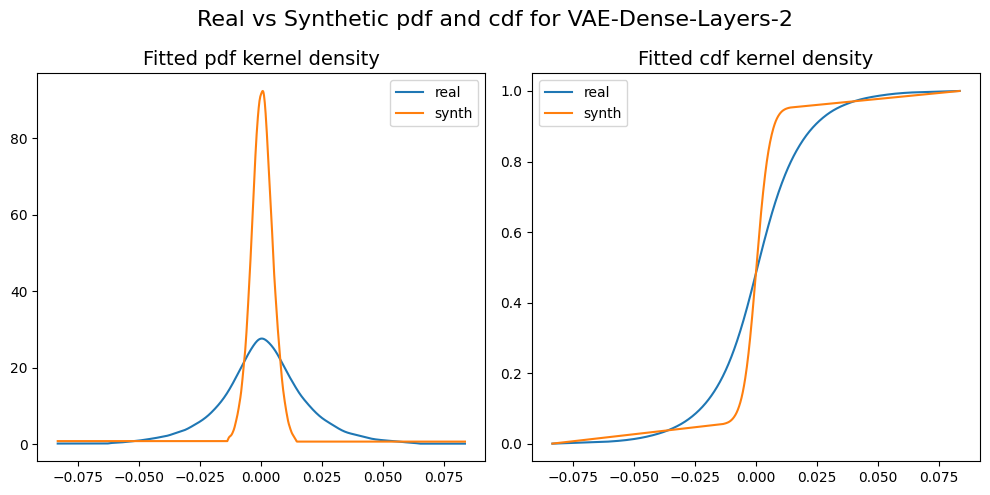

Model:  VQ-VAE-Convolutional
Synth:  (111104,)
Reject outliers: 1.34%
Max before: 0.17, Max now: 0.05
Min before: -0.18, Min now: -0.04
Synth clean:  109612


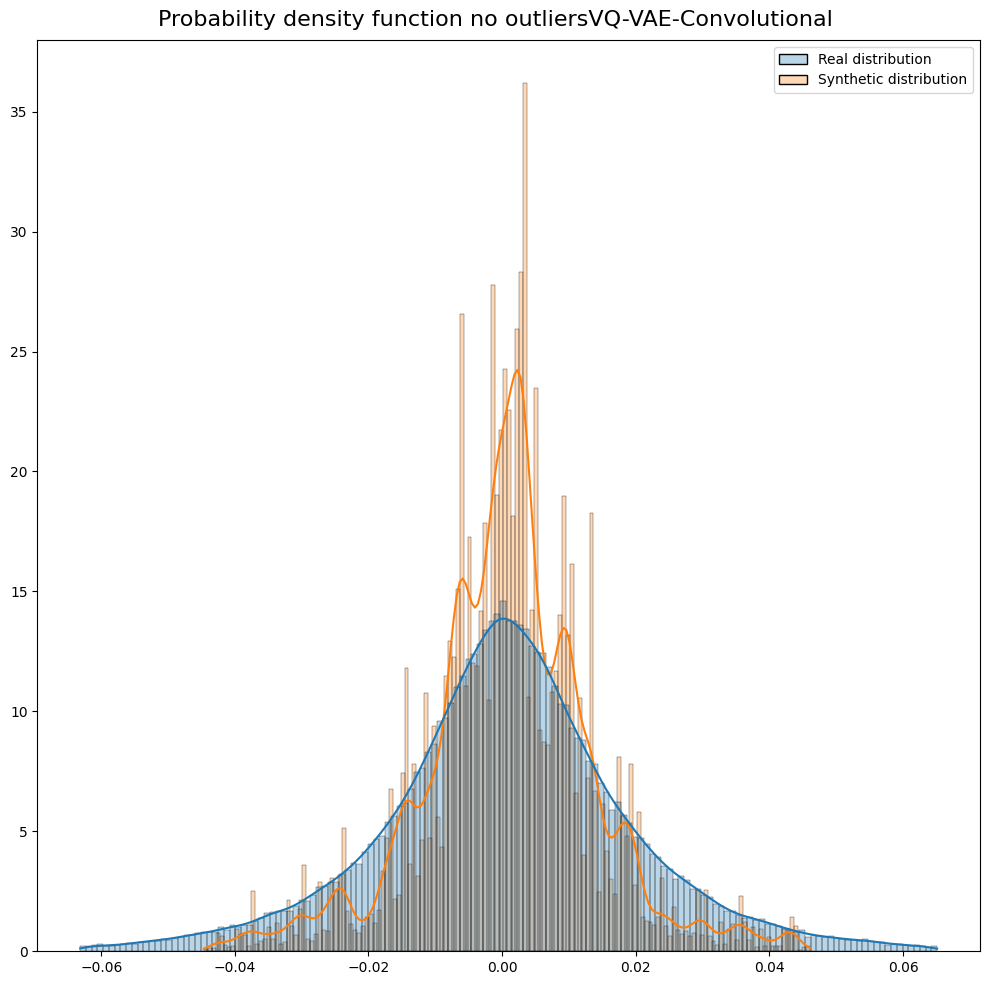

Synth pdf area:  0.9999999999999998


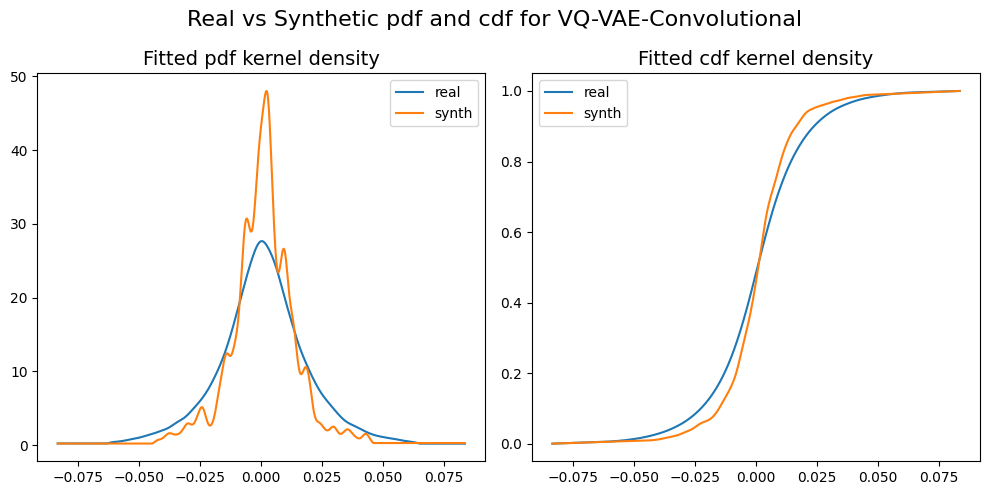

Model:  VQ-VAE-Dense-Layers
Synth:  (111104,)
Reject outliers: 0.39%
Max before: 0.06, Max now: 0.03
Min before: -0.04, Min now: -0.03
Synth clean:  110667


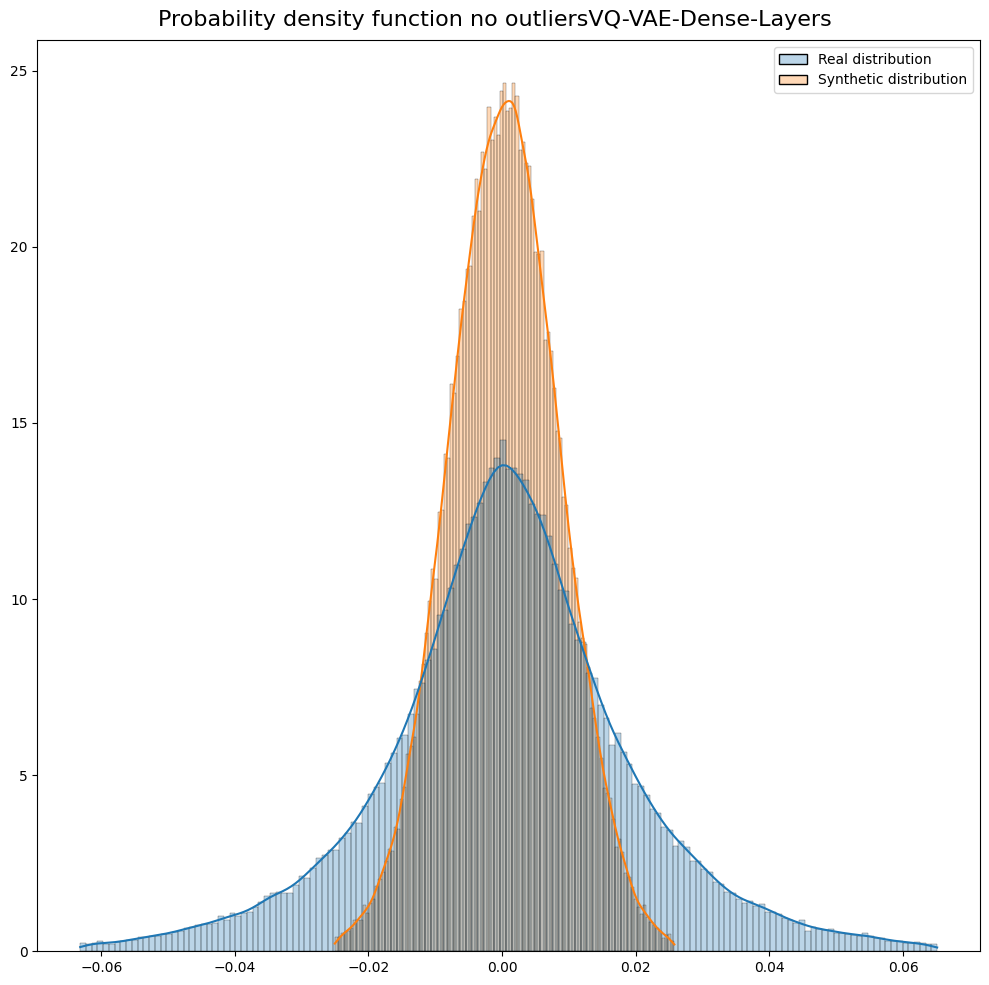

Synth pdf area:  1.0


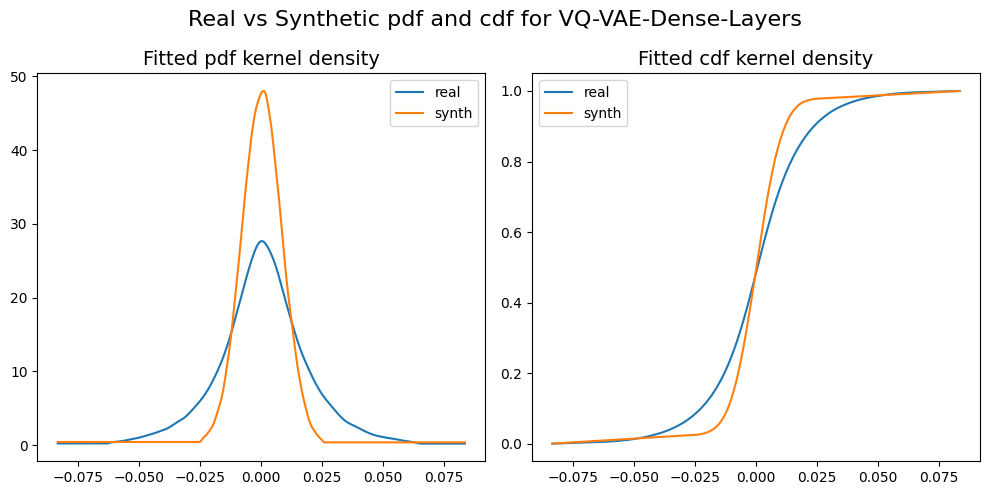

In [28]:

i = 0
sample =1000 
real = data_eval[i].flatten()
print("Real: ", real.shape[0])
real_clean = remove_outliers(real,  verbose =True)
print("Real clean: ", real_clean.shape[0])
X = get_domain(generated, real_clean, sample=sample ,drop_outliers=True)
real_pdf = kernel_pdf(real_clean, X)
real_pdf_std = real_pdf/np.sum(real_pdf)
print("Real pdf area: ", real_pdf_std.sum())
real_cdf = np.cumsum(real_pdf_std)

for model_name, synth in generated.items():
        model = model_name.strip()
        model = model.replace(' ', '-')
        synth_ft = synth.flatten()
        print('Model: ', model)       
        print("Synth: ", synth_ft.shape)
        synth_clean = remove_outliers(synth_ft, verbose =True)
        print("Synth clean: ", synth_clean.shape[0])
        # fig, ax1 = plt.subplots()
        # ax1.hist([real_clean, synth_clean],color=['blue', 'orange'], bins= 100, label=['real', 'synth'])
        # ax1.set_ylabel("Count")
        # ax1.legend()
        # plt.tight_layout()
        # plt.show()

        # plot_density(real_clean, synth_clean)
        # PLot density 
        real_df = pd.DataFrame(real_clean)
        real_df['label'] = 'Real distribution'
        real_df.columns = ['value', 'label']
        synth_df = pd.DataFrame(synth_clean)
        synth_df['label'] = 'Synthetic distribution'
        synth_df.columns = ['value', 'label']
        df = pd.concat([real_df, synth_df])
        fig, axes = plt.subplots(figsize=(10,10) ) 
        title = 'Probability density function no outliers' + model
        fig.suptitle(title, fontsize=16 )

        g =sns.histplot(df,
        bins='auto',
        kde=True,
        x = 'value',
        hue='label',
        stat="density",
        # facet_kws={'legend_out': False}, 
        alpha=0.3,
        common_bins=False,
        # ax=axes[i//2, i%2]
                )
        g.set(xlabel= None, ylabel= None )
        g.legend_.set_title(None)
        plt.tight_layout()
        plt.show()

        file_name = plots + model + '/'+model+'_pdf_outliers.png'
        file_name = file_name.replace(' ', '_')
        file_name = file_name.replace('-', '_')
        file_name = file_name.lower()
        fig.savefig(file_name, dpi=fig.dpi)
        plt.close(fig)

        # Plot pdf and cdf
        synth_pdf = kernel_pdf(synth_clean, X)
        synth_pdf_std = synth_pdf/np.sum(synth_pdf)
        
        print("Synth pdf area: ", synth_pdf_std.sum())
        synth_cdf = np.cumsum(synth_pdf_std)

        fig, ax = plt.subplots(1,2, figsize=(10,5))
        title = 'Real vs Synthetic pdf and cdf for ' + model
        fig.suptitle(title, fontsize=16)


        ax[0].set_title("Fitted pdf kernel density", fontsize=14)
        ax[0].plot(X, real_pdf, label='real')
        ax[0].plot(X, synth_pdf, label='synth')
        ax[0].legend()

        ax[1].set_title("Fitted cdf kernel density", fontsize=14)
        ax[1].plot(X, real_cdf, label='real')
        ax[1].plot(X, synth_cdf, label='synth')
        ax[1].legend()
        plt.tight_layout()
        plt.show()     
        file_name = plots + model+ '/'+model + '_pdf_cdf' + '.png'
        file_name = file_name.replace(' ', '_')
        file_name = file_name.replace('-', '_')
        file_name = file_name.lower()
        fig.savefig(file_name, dpi=fig.dpi)
        plt.close(fig)



Real:  111104
Reject outliers: 1.35%
Max before: 0.49, Max now: 0.07
Min before: -0.34, Min now: -0.06
Real clean:  109606
Real pdf area:  1.0
Model:  TIME-VAE-BASE
Synth:  (111104,)
Reject outliers: 0.92%
Max before: 0.04, Max now: 0.02
Min before: -0.10, Min now: -0.02
Synth clean:  110079


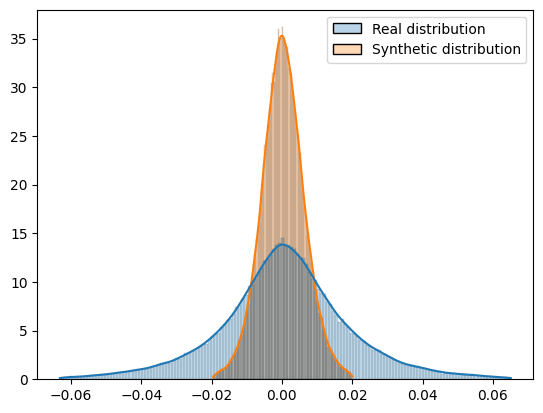

Synth pdf area:  1.0


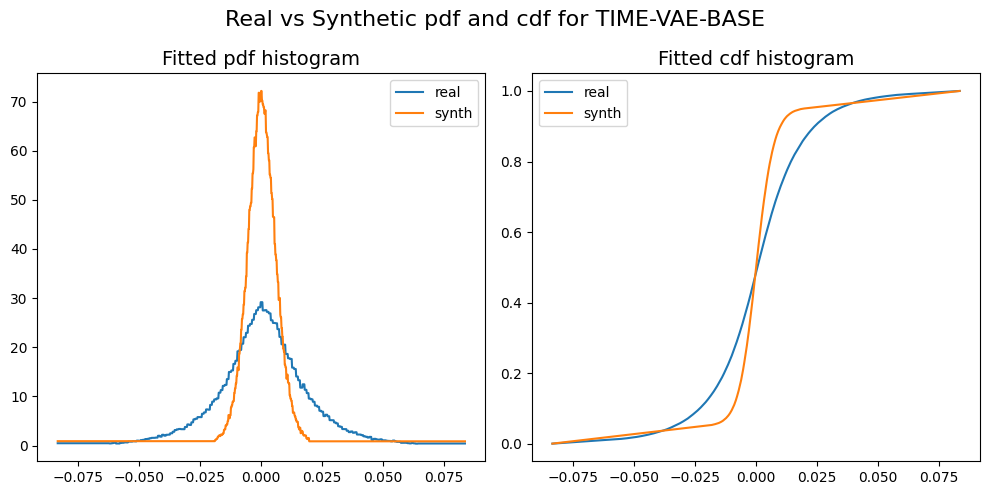

Model:  VAE-Convolutional-1
Synth:  (111104,)
Reject outliers: 0.54%
Max before: 0.04, Max now: 0.02
Min before: -0.04, Min now: -0.02
Synth clean:  110504


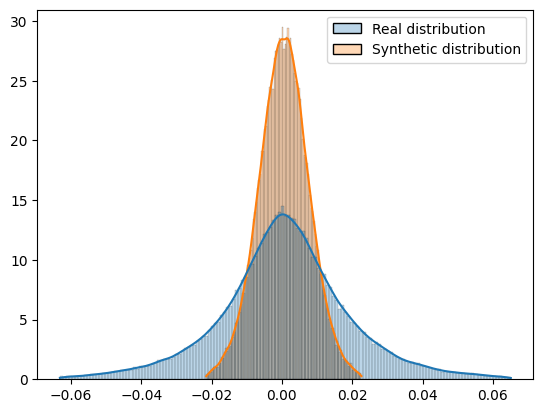

Synth pdf area:  1.0


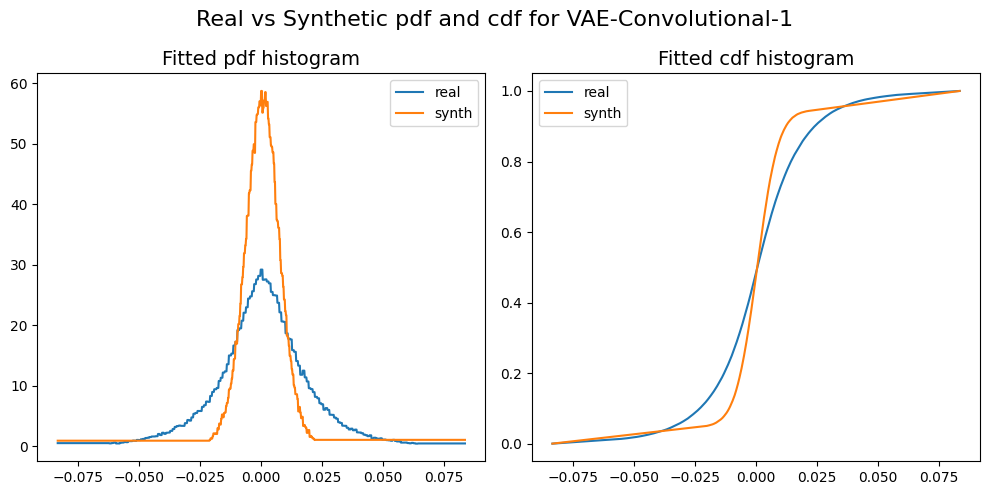

Model:  VAE-Convolutional-2
Synth:  (111104,)
Reject outliers: 0.37%
Max before: 0.15, Max now: 0.08
Min before: -0.13, Min now: -0.08
Synth clean:  110688


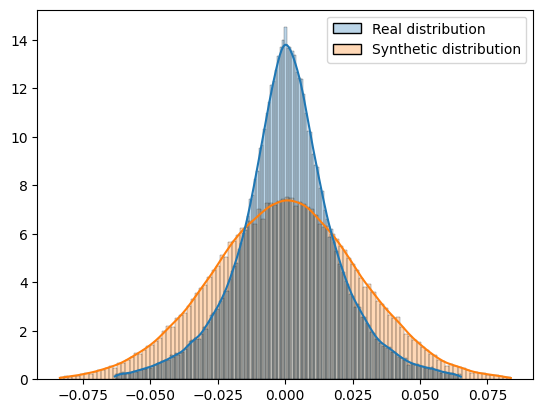

Synth pdf area:  1.0


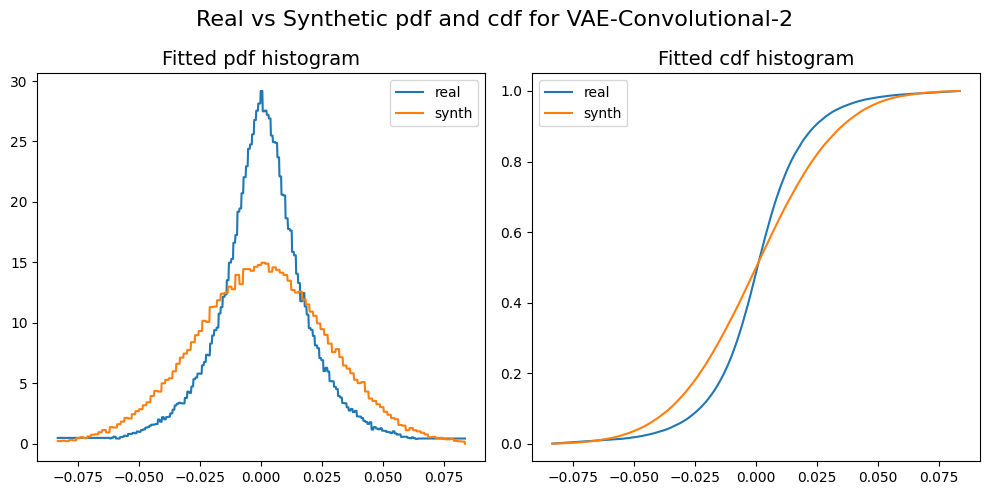

Model:  VAE-Dense-Layers-1
Synth:  (111104,)
Reject outliers: 0.95%
Max before: 0.11, Max now: 0.04
Min before: -0.09, Min now: -0.04
Synth clean:  110053


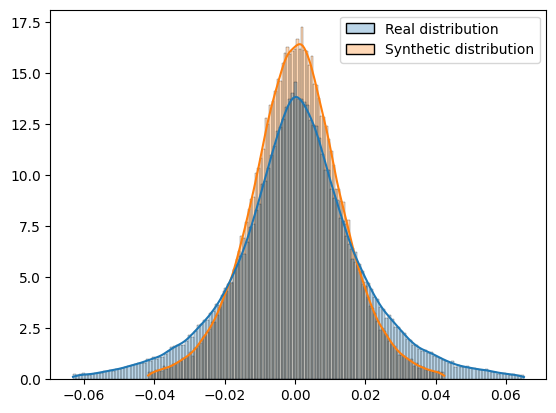

Synth pdf area:  1.0


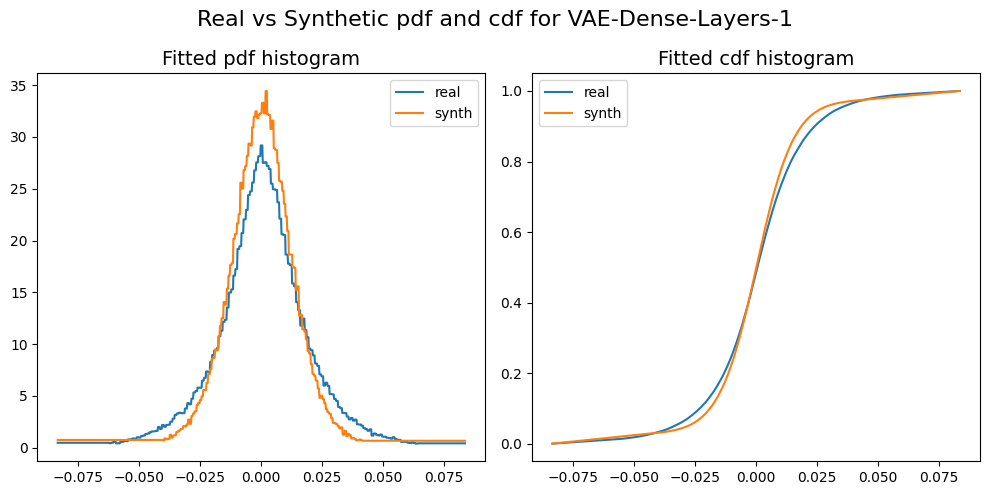

Model:  VAE-Dense-Layers-2
Synth:  (111104,)
Reject outliers: 0.78%
Max before: 0.04, Max now: 0.01
Min before: -0.04, Min now: -0.01
Synth clean:  110232


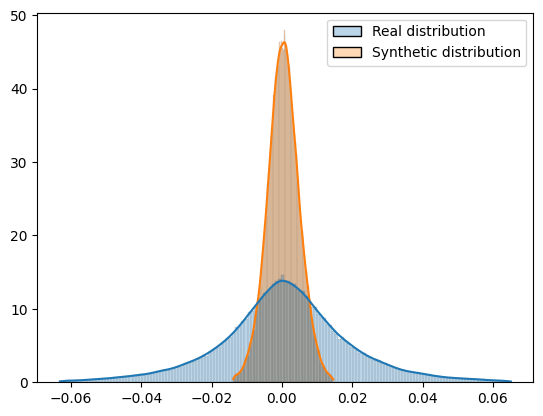

Synth pdf area:  1.0000000000000004


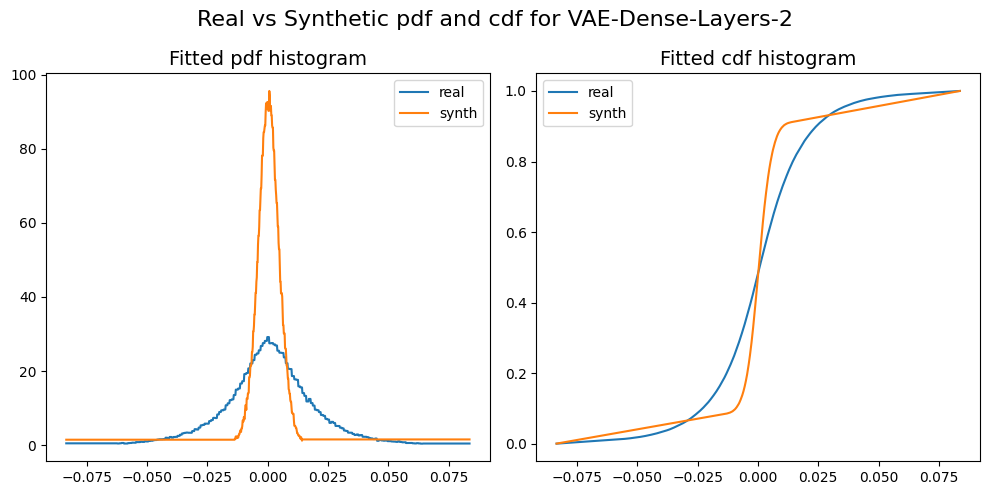

Model:  VQ-VAE-Convolutional
Synth:  (111104,)
Reject outliers: 1.34%
Max before: 0.17, Max now: 0.05
Min before: -0.18, Min now: -0.04
Synth clean:  109612


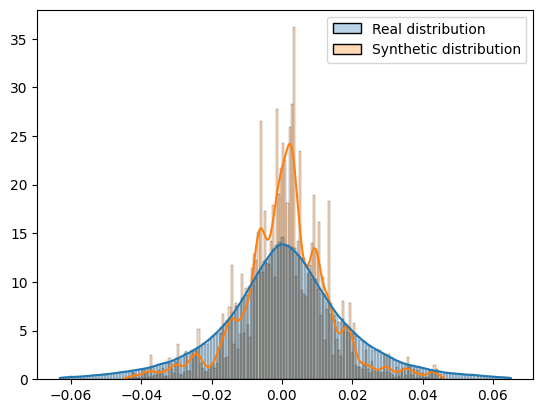

Synth pdf area:  1.0


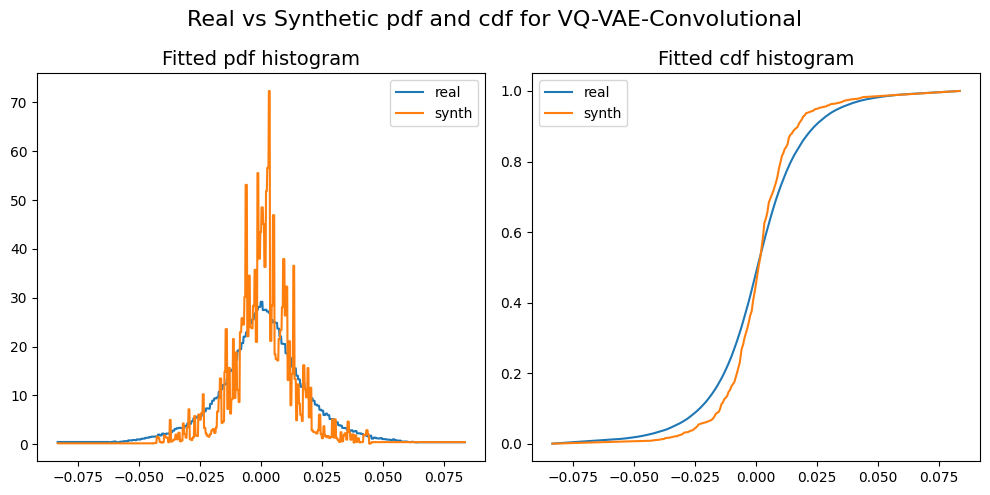

Model:  VQ-VAE-Dense-Layers
Synth:  (111104,)
Reject outliers: 0.39%
Max before: 0.06, Max now: 0.03
Min before: -0.04, Min now: -0.03
Synth clean:  110667


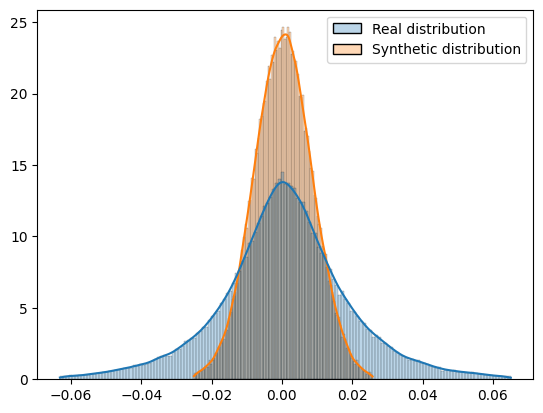

Synth pdf area:  1.0


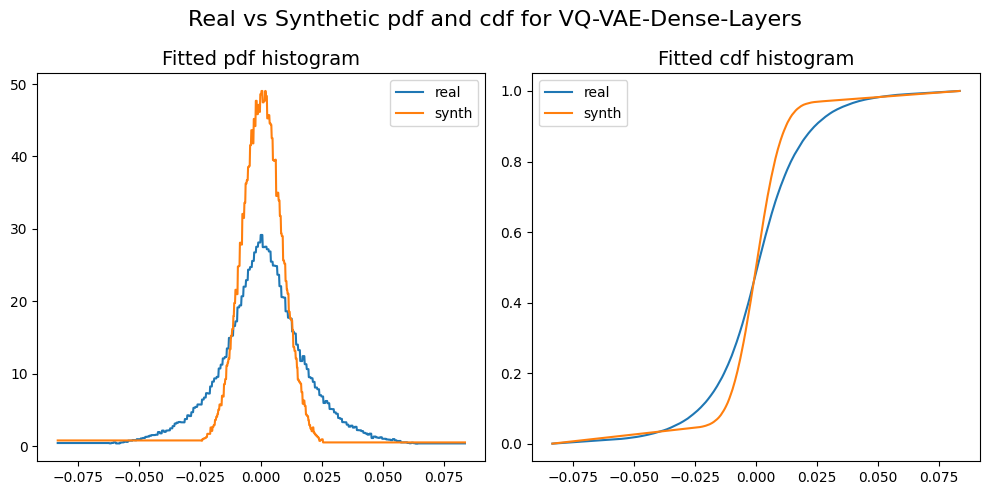

In [29]:

i = 0
sample =1000 
real = data_eval[i].flatten()
print("Real: ", real.shape[0])
real_clean = remove_outliers(real,  verbose =True)
print("Real clean: ", real_clean.shape[0])
X = get_domain(generated, real_clean, sample=sample ,drop_outliers=True)
real_pdf = histogram_pdf(real_clean, X)
real_pdf_std = real_pdf/np.sum(real_pdf)
print("Real pdf area: ", real_pdf_std.sum())
real_cdf = np.cumsum(real_pdf_std)

for model_name, synth in generated.items():
        model = model_name.strip()
        model = model.replace(' ', '-')
        synth_ft = synth.flatten()
        print('Model: ', model)       
        print("Synth: ", synth_ft.shape)
        synth_clean = remove_outliers(synth_ft, verbose =True)
        print("Synth clean: ", synth_clean.shape[0])
        # fig, ax1 = plt.subplots()
        # ax1.hist([real_clean, synth_clean],color=['blue', 'orange'], bins= 100, label=['real', 'synth'])
        # ax1.set_ylabel("Count")
        # ax1.legend()
        # plt.tight_layout()
        # plt.show()

        plot_density(real_clean, synth_clean)


        # Plot pdf and cdf
        synth_pdf = histogram_pdf(synth_clean, X)
        synth_pdf_std = synth_pdf/np.sum(synth_pdf)
        
        print("Synth pdf area: ", synth_pdf_std.sum())
        synth_cdf = np.cumsum(synth_pdf_std)

        fig, ax = plt.subplots(1,2, figsize=(10,5))
        title = 'Real vs Synthetic pdf and cdf for ' + model
        fig.suptitle(title, fontsize=16)


        ax[0].set_title("Fitted pdf histogram", fontsize=14)
        ax[0].plot(X, real_pdf, label='real')
        ax[0].plot(X, synth_pdf, label='synth')
        ax[0].legend()

        ax[1].set_title("Fitted cdf histogram", fontsize=14)
        ax[1].plot(X, real_cdf, label='real')
        ax[1].plot(X, synth_cdf, label='synth')
        ax[1].legend()
        plt.tight_layout()
        plt.show()     
        file_name = plots + model+ '/'+model + 'hist_pdf_cdf' + '.png'
        file_name = file_name.replace(' ', '_')
        file_name = file_name.replace('-', '_')
        file_name = file_name.lower()
        fig.savefig(file_name, dpi=fig.dpi)
        plt.close(fig)



## Fitting Kernel

In [65]:
import scipy.stats as stats
def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 3.49 * std_dev * n ** (-0.333)
def bw_silverman(data: np.ndarray):
    def _select_sigma(x):
        normalizer = 1.349
        iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
        std_dev = np.std(x, axis=0, ddof=1)
        return np.minimum(std_dev, iqr) if iqr > 0 else std_dev
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

In [66]:
bw_scott(array)

0.0009452693021510046

In [67]:
bw_silverman(array)

0.0009274646952362523

In [138]:

array = vqvaeconv2.flatten()
array = remove_outliers(array)
# ilverman rule of thumb
bandwidth = 1.06 * array.std() * array.size ** (-1 / 5.)
bandwidth 

0.0013438015544241842

In [137]:
# scots rule of thumb
bandwidth = 3.49 * array.std() * array.size ** (-1 / 3.)
bandwidth 

0.0009416155470368562

In [151]:
array1 = remove_outliers(data_eval[0].flatten())
min_loc = np.min(array1)
max_loc = np.max(array1)
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(array.reshape(-1, 1))
synth_X = np.linspace(min_loc, max_loc, 100)
synth_pr = np.exp(kde.score_samples(synth_X.reshape(-1, 1)))

In [152]:
synth_X

array([-0.06314665, -0.06185112, -0.06055559, -0.05926006, -0.05796453,
       -0.056669  , -0.05537347, -0.05407793, -0.0527824 , -0.05148687,
       -0.05019134, -0.04889581, -0.04760028, -0.04630475, -0.04500922,
       -0.04371369, -0.04241815, -0.04112262, -0.03982709, -0.03853156,
       -0.03723603, -0.0359405 , -0.03464497, -0.03334944, -0.03205391,
       -0.03075837, -0.02946284, -0.02816731, -0.02687178, -0.02557625,
       -0.02428072, -0.02298519, -0.02168966, -0.02039413, -0.01909859,
       -0.01780306, -0.01650753, -0.015212  , -0.01391647, -0.01262094,
       -0.01132541, -0.01002988, -0.00873435, -0.00743881, -0.00614328,
       -0.00484775, -0.00355222, -0.00225669, -0.00096116,  0.00033437,
        0.0016299 ,  0.00292543,  0.00422097,  0.0055165 ,  0.00681203,
        0.00810756,  0.00940309,  0.01069862,  0.01199415,  0.01328968,
        0.01458521,  0.01588075,  0.01717628,  0.01847181,  0.01976734,
        0.02106287,  0.0223584 ,  0.02365393,  0.02494946,  0.02

In [153]:
synth_pr

array([1.52452299e-43, 5.61917062e-38, 8.18226303e-33, 4.70856312e-28,
       1.07139306e-23, 9.64757035e-20, 3.44254234e-16, 4.87866960e-13,
       2.75655431e-10, 6.25437895e-08, 5.78035335e-06, 2.24310038e-04,
       3.89472155e-03, 3.37443907e-02, 1.62566225e-01, 4.46365706e-01,
       7.08293086e-01, 8.38690147e-01, 1.12563365e+00, 1.50595539e+00,
       1.63088034e+00, 1.48939403e+00, 1.46189262e+00, 1.65337318e+00,
       2.18026887e+00, 2.80962937e+00, 2.93403622e+00, 2.80609589e+00,
       3.37682979e+00, 4.51159391e+00, 5.15929675e+00, 4.23612929e+00,
       2.89156060e+00, 2.79553186e+00, 4.09770079e+00, 6.50698951e+00,
       9.01262517e+00, 1.14282758e+01, 1.24601271e+01, 1.21065768e+01,
       1.31074647e+01, 1.53099712e+01, 1.97194522e+01, 2.65222652e+01,
       3.06277535e+01, 2.96154119e+01, 2.94117252e+01, 3.39757296e+01,
       4.00044325e+01, 4.42174438e+01, 4.74521045e+01, 4.67069836e+01,
       3.83250489e+01, 2.85007019e+01, 2.35677492e+01, 2.49149027e+01,
      

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_26402/2563251610.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


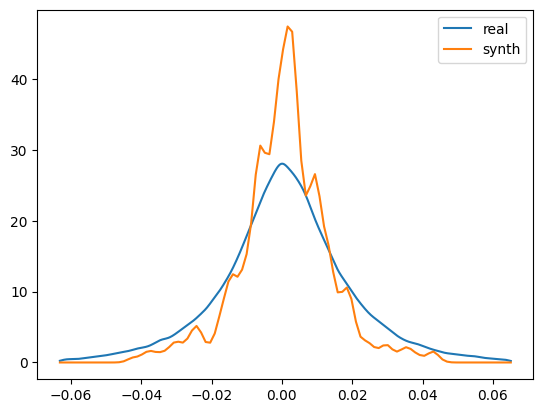

In [154]:
real_pr, real_X =  kernel_pdf1(data_eval[0].flatten(), sample=1000)
fig, ax = plt.subplots()
ax.plot(real_X, real_pr, label='real')
ax.plot(synth_X, synth_pr, label='synth')
ax.legend()
fig.show()

In [70]:
def kernel_pdf1(array, sample=1000):
    array = remove_outliers(array)
    bandwidth = 1.06 * array.std() * array.size ** (-1 / 5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw_silverman(array)).fit(array.reshape(-1, 1))
    X = np.linspace(np.min(array), np.max(array), sample)
    probabilities = np.exp(kde.score_samples(X.reshape(-1, 1)))
    return probabilities, X

In [25]:
synth_pr, synth_X =  kernel_pdf1(vqvaefd1.flatten(), sample=1000)
real_pr, real_X =  kernel_pdf1(data_eval[0].flatten(), sample=1000)
synth_pdf = synth_pr/ np.sum(synth_pr)
real_pdf = real_pr/ np.sum(real_pr) 

In [154]:
synth_pdf = synth_pr/ np.sum(synth_pr)
real_pdf = real_pr/ np.sum(real_pr) 

In [155]:
synth_pr = np.exp(synth_pr)
real_pr= np.exp(real_pr)
synth_pdf = synth_pr/ np.sum(synth_pr)
real_pdf = real_pr/ np.sum(real_pr)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_1586/3221899061.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


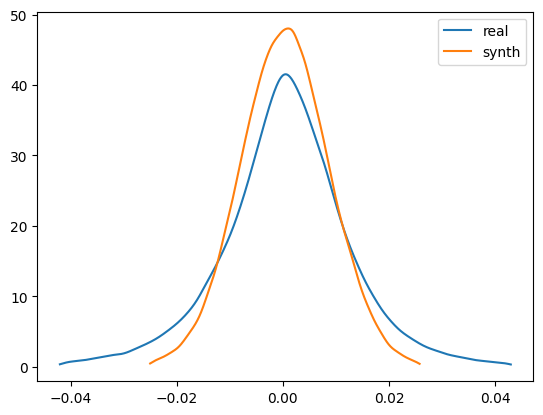

In [156]:
fig, ax = plt.subplots()
ax.plot(real_X, real_pr, label='real')
ax.plot(synth_X, synth_pr, label='synth')
ax.legend()
fig.show()

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_1586/741156206.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


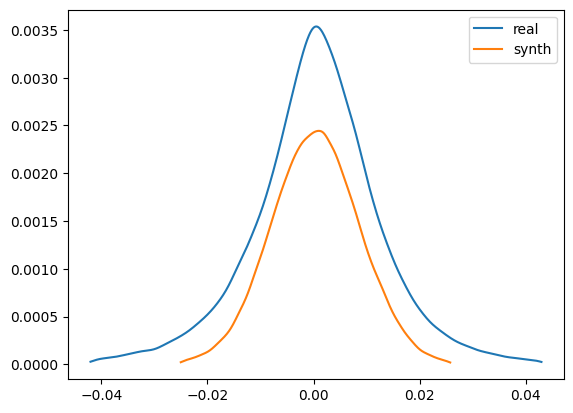

In [157]:
fig, ax = plt.subplots()
ax.plot(real_X, real_pdf, label='real')
ax.plot(synth_X, synth_pdf, label='synth')
ax.legend()
fig.show()

In [158]:
jensenshannon(p = synth_pr, q=real_pr)

0.10164634518952725

In [159]:
np.sum(rel_entr(synth_pr, real_pr))

10951.274172930296

## Fitting histogram 

In [465]:
synth.shape

(111104,)

In [155]:
array = synth
density = True
bins='auto'
sample = 300
#Get histogram

hist, bin_edges =  np.histogram(array, bins=bins, density=density)
hist_norm = hist / np.sum(hist)
bin_edges_norm = bin_edges / np.sum(hist)
# if w:
#     print('Adding prior correction to histogram')
#     histogram_dist = rv_histogram((
#         np.histogram(array, bins=bins, density=density)[0] + w * np.ones(len(hist)),
#         bin_edges)
#         ,density=density)
# else:
histogram_dist = rv_histogram((hist, bin_edges),density=density)

#Generate arrays of pdf evaluations
X = np.linspace(np.min(array), np.max(array), sample)

rvs_array = np.array([histogram_dist.pdf(x) for x in X])


In [156]:
histogram_dist.pdf(np.min(array)-0.2)

0.0

In [468]:
sum(rvs_array)

3996.1614437598264

In [472]:
pdf = rvs_array/sum(rvs_array)

In [476]:
cdf = np.cumsum(pdf)

/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_61264/2438387165.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


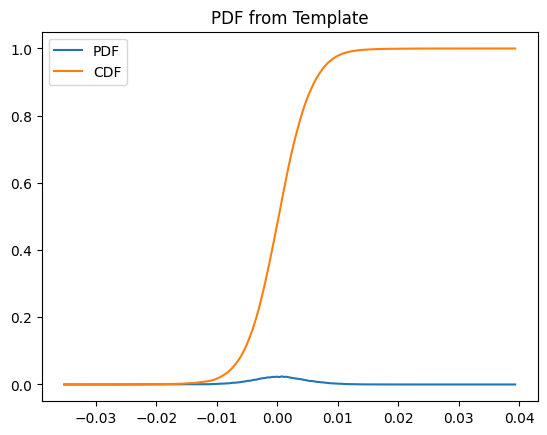

In [477]:

fig, ax = plt.subplots()
ax.set_title("PDF from Template")
# ax.hist(array, density=True, bins=100)

ax.plot(X, pdf, label='PDF')
ax.plot(X, cdf, label='CDF')
ax.legend()
fig.show()

## Jensen divergence

In [625]:
real.shape

(111104,)

In [626]:
synth = vaefd2.flatten()
real = data_eval[0].flatten()
sample =380 # sample calculator
outlier_rejection=True
m=10
bins='auto'
density=True
w=None
correct_for_bias=True

p = get_pdf(synth, sample=sample, by_hist= False,w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)
q = get_pdf(real, sample=sample, by_hist= False, w=w, bins=bins, density=density, outlier_rejection=outlier_rejection, m=m)


In [627]:
q

array([2.64399362e-05, 2.55806081e-05, 2.48536012e-05, 2.43750558e-05,
       2.42151548e-05, 2.43980374e-05, 2.49116965e-05, 2.57240320e-05,
       2.67992521e-05, 2.81084099e-05, 2.96300630e-05, 3.13414908e-05,
       3.32056329e-05, 3.51613555e-05, 3.71233002e-05, 3.89929724e-05,
       4.06772480e-05, 4.21069311e-05, 4.32481407e-05, 4.41029220e-05,
       4.47005634e-05, 4.50850193e-05, 4.53047702e-05, 4.54092517e-05,
       4.54520330e-05, 4.54971851e-05, 4.56233185e-05, 4.59203416e-05,
       4.64769273e-05, 4.73610334e-05, 4.85999497e-05, 5.01683076e-05,
       5.19908711e-05, 5.39617198e-05, 5.59744554e-05, 5.79524771e-05,
       5.98672609e-05, 6.17372641e-05, 6.36089070e-05, 6.55297721e-05,
       6.75278364e-05, 6.96067252e-05, 7.17574996e-05, 7.39778862e-05,
       7.62859950e-05, 7.87197277e-05, 8.13223743e-05, 8.41232064e-05,
       8.71240914e-05, 9.02985612e-05, 9.36021686e-05, 9.69876164e-05,
       1.00417952e-04, 1.03874932e-04, 1.07363670e-04, 1.10915663e-04,
      

In [596]:
p

array([4.20668589e-06, 4.70711947e-06, 4.95551620e-06, 4.95667262e-06,
       4.76393045e-06, 4.45162454e-06, 4.08949070e-06, 3.73063601e-06,
       3.41126744e-06, 3.15256064e-06, 2.95901093e-06, 2.81738047e-06,
       2.70479141e-06, 2.60867022e-06, 2.55043775e-06, 2.59860277e-06,
       2.86034138e-06, 3.45118207e-06, 4.45325470e-06, 5.87792518e-06,
       7.64672282e-06, 9.59716847e-06, 1.15111739e-05, 1.31568591e-05,
       1.43323063e-05, 1.49019151e-05, 1.48201264e-05, 1.41401038e-05,
       1.30055572e-05, 1.16247146e-05, 1.02295259e-05, 9.02995514e-06,
       8.17780958e-06, 7.75195756e-06, 7.76673230e-06, 8.19330335e-06,
       8.97786788e-06, 1.00460368e-05, 1.12976140e-05, 1.26092413e-05,
       1.38609630e-05, 1.49834863e-05, 1.59995268e-05, 1.70265597e-05,
       1.82286359e-05, 1.97378531e-05, 2.15863112e-05, 2.36826284e-05,
       2.58408463e-05, 2.78437773e-05, 2.95124776e-05, 3.07590014e-05,
       3.16106466e-05, 3.22007864e-05, 3.27244023e-05, 3.33649010e-05,
      

In [628]:
print(sum(p>1), sum(q>1))
print(p.shape, q.shape)

0 0
(380,) (380,)


In [629]:
ps = pd.Series(p)
ps.value_counts()

0.000395    1
0.003646    1
0.003133    1
0.003187    1
0.003242    1
           ..
0.003188    1
0.003140    1
0.003093    1
0.003047    1
0.000336    1
Name: count, Length: 380, dtype: int64

In [630]:
p = np.array(p)
q = np.array(q)
# calculate m
m = (p + q) / 2
m.shape


(380,)

In [631]:
scipy.stats.entropy(p, q)

0.42398862392916703

In [632]:
scipy.stats.entropy(p, m)

0.07160083742482898

In [633]:
scipy.stats.entropy(q, m)

0.09300394195727545

In [634]:
np.sum(kl_div(p,q))

0.42398862392916703

In [635]:
np.sum(kl_div(p,m))

0.07160083742482903

In [636]:
np.sum(kl_div(q,m))

0.0930039419572754

In [637]:
np.sum(rel_entr(p,q))

0.42398862392916703

In [638]:
np.sum(rel_entr(p,m))

0.07160083742482898

In [639]:
np.sum(rel_entr(q,m))

0.09300394195727545

In [640]:
divergence = (np.sum(kl_div(p, m)) + np.sum(kl_div(q, m))) / 2
# compute the Jensen Shannon distance
distance = np.sqrt(divergence)
print(distance)

0.28688393069506735


In [641]:
jensenshannon(p,q)

0.28688393069506735

In [642]:
    if correct_for_bias:
        return np.sum(kl_div(synth_pdf, real_pdf)), js
    else:
        entropy = rel_entr(synth_pdf, real_pdf)
        return np.sum(entropy), js

SyntaxError: 'return' outside function (572813585.py, line 2)

In [643]:
# compute Jensen Shannon divergence
divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2
# compute the Jensen Shannon distance
distance = np.sqrt(divergence)

In [644]:
print('p shape: ', p.shape)
print('q shape: ', q.shape)

p shape:  (380,)
q shape:  (380,)


In [645]:
p[2]==0

False

In [646]:
p[p!=0].shape

(380,)

In [647]:
cond = p!=0
p = p[cond]
q = q[cond]
# calculate m
m = (p + q) / 2
print('p shape: ', p.shape)
print('q shape: ', q.shape)
print('m shape: ', m.shape)

p shape:  (380,)
q shape:  (380,)
m shape:  (380,)


In [648]:
sum(cond)

380

In [649]:
kl_divergence( p, q)

0.423988623929167

In [650]:
kl_divergence( p, m)

0.07160083742482899

In [651]:
kl_divergence( q, m)

0.09300394195727549

In [652]:
kl_divergence( p, p)

0.0

In [653]:
q

array([2.64399362e-05, 2.55806081e-05, 2.48536012e-05, 2.43750558e-05,
       2.42151548e-05, 2.43980374e-05, 2.49116965e-05, 2.57240320e-05,
       2.67992521e-05, 2.81084099e-05, 2.96300630e-05, 3.13414908e-05,
       3.32056329e-05, 3.51613555e-05, 3.71233002e-05, 3.89929724e-05,
       4.06772480e-05, 4.21069311e-05, 4.32481407e-05, 4.41029220e-05,
       4.47005634e-05, 4.50850193e-05, 4.53047702e-05, 4.54092517e-05,
       4.54520330e-05, 4.54971851e-05, 4.56233185e-05, 4.59203416e-05,
       4.64769273e-05, 4.73610334e-05, 4.85999497e-05, 5.01683076e-05,
       5.19908711e-05, 5.39617198e-05, 5.59744554e-05, 5.79524771e-05,
       5.98672609e-05, 6.17372641e-05, 6.36089070e-05, 6.55297721e-05,
       6.75278364e-05, 6.96067252e-05, 7.17574996e-05, 7.39778862e-05,
       7.62859950e-05, 7.87197277e-05, 8.13223743e-05, 8.41232064e-05,
       8.71240914e-05, 9.02985612e-05, 9.36021686e-05, 9.69876164e-05,
       1.00417952e-04, 1.03874932e-04, 1.07363670e-04, 1.10915663e-04,
      

In [654]:
m

array([0.00021054, 0.00021398, 0.00021751, 0.00022119, 0.00022504,
       0.00022908, 0.00023331, 0.00023771, 0.00024227, 0.00024698,
       0.00025184, 0.00025682, 0.00026193, 0.00026713, 0.00027239,
       0.00027766, 0.0002829 , 0.00028807, 0.00029318, 0.00029822,
       0.00030321, 0.00030818, 0.00031316, 0.00031818, 0.00032327,
       0.00032847, 0.00033381, 0.00033935, 0.00034512, 0.00035117,
       0.0003575 , 0.0003641 , 0.00037093, 0.00037793, 0.00038505,
       0.00039223, 0.00039947, 0.00040677, 0.00041415, 0.00042162,
       0.00042921, 0.00043692, 0.00044473, 0.00045266, 0.00046072,
       0.00046893, 0.00047732, 0.00048591, 0.00049471, 0.00050371,
       0.00051291, 0.00052228, 0.00053181, 0.0005415 , 0.00055137,
       0.00056142, 0.00057171, 0.00058227, 0.00059315, 0.00060442,
       0.00061609, 0.00062817, 0.00064064, 0.00065345, 0.00066655,
       0.00067989, 0.00069345, 0.00070726, 0.00072135, 0.0007358 ,
       0.00075066, 0.000766  , 0.00078185, 0.00079822, 0.00081

In [655]:
np.log(q/m)

array([-2.0748151 , -2.12406598, -2.16925403, -2.20544044, -2.22928378,
       -2.23956385, -2.23702401, -2.22363303, -2.20169577, -2.17325828,
       -2.13999388, -2.10344941, -2.06536371, -2.02779866, -1.99299042,
       -1.96301039, -1.93941081, -1.92300242, -1.91382535, -1.91129254,
       -1.9144322 , -1.92213339, -1.93330637, -1.94690711, -1.96183636,
       -1.97678665, -1.99015188, -2.00011121, -2.00493768, -2.00346377,
       -1.99551042, -1.98204507, -1.96494352, -1.94643504, -1.92846605,
       -1.91223029, -1.8980126 , -1.88535834, -1.87346362, -1.86160371,
       -1.84940844, -1.836878  , -1.82417908, -1.8113805 , -1.79830195,
       -1.7845595 , -1.76976376, -1.75373943, -1.7366369 , -1.71888665,
       -1.70104359, -1.68361516, -1.66694413, -1.65116087, -1.63617888,
       -1.62170578, -1.60726818, -1.59227265, -1.57612296, -1.55838241,
       -1.53893024, -1.51804286, -1.49635203, -1.47468468, -1.45384086,
       -1.43438903, -1.41654427, -1.4001592 , -1.38481772, -1.36

In [656]:
def kl_divergence( p, q):
    """ Compute KL divergence of two vectors, K(p || q)."""
    kl = 0
    for x in range(len(p)):
        if p[x] != 0.0 or p[x] != 0.0:
            # print('zero value')
            kl+=p[x] * np.log((p[x]) / (q[x]))
    return kl


def Jensen_Shannon_divergence(self, p, q):
    """ Returns the Jensen-Shannon divergence. """

    weight = 0.5
    average = zeros(len(p)) #Average
    for x in range(len(p)):
        average[x] = weight * p[x] + (1 - weight) * q[x]
        JSD = (weight * self.KL_divergence(array(p), average)) + ((1 - weight) * self.KL_divergence(array(q), average))
        return 1-(JSD/sqrt(2 * self.log2))